**Review**
	  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job! I liked that you experimented much more than the project description suggested. That's the spirit! The project is accepted. Good luck on the next sprint! :)

<div class="alert alert-info" role="alert">
Dear Reviewer, 
    
<br>Thank you for reviewing my work. 

    
<br>Rena Bracha
</div>

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
You're welcome! :)
	  
</div>

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.


**Project Outline**
<br>The following models will be compared for their performance 
* Logistic regression
* LightGBM classifier
* BERT

on three datasets offering varying degrees of information. NLTK and spacCy lemmatisations were compared in terms of model performance. 


**Dataset**
<br>The main columns particularly relevant to the project:
* review: the review text
* pos: the target, '0' for negative and '1' for positive
* ds_part: 'train'/'test' for the train/test part of dataset, correspondingly


## Tables of Contents <a class="anchor" id="table_of_contents"></a>

* [Initialization](#chapter1)
* [Load Data](#chapter2)
* [EDA](#chapter3)
* [Evaluation Procedure](#chapter4)
* [Normalization](#chapter5)
* [Train/Test Split](#chapter6)
* [Working with models](#chapter7)
    * [Model 0 - Constant](#section_7_1)
    * [Model 1 - NLTK, TF-IDF and LR](#section_7_2)
    * [Model 3 - spaCy, TF-IDF and LR](#section_7_3)
    * [Model 4 - spaCy, TF-IDF and LGBMClassifier](#section_7_4)
    * [Model 9 - BERT](#section_7_5)
* [My Reviews](#chapter8)
    * [Model 1](#section_8_1)
    * [Model 3](#section_8_2)
    * [Model 4](#section_8_3)
    * [Model 5](#section_8_4)
    * [Model 9](#section_8_5)
* [Conclusions](#chapter9)

## Initialization

In [ ]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.metrics import f1_score

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [ ]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

**Load the first 500 rows for starters.**

In [5]:
try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'}, nrows=500)
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'}, nrows=500)

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           500 non-null    object 
 1   title_type       500 non-null    object 
 2   primary_title    500 non-null    object 
 3   original_title   500 non-null    object 
 4   start_year       500 non-null    int64  
 5   end_year         500 non-null    object 
 6   runtime_minutes  500 non-null    object 
 7   is_adult         500 non-null    int64  
 8   genres           500 non-null    object 
 9   average_rating   500 non-null    float64
 10  votes            500 non-null    Int64  
 11  review           500 non-null    object 
 12  rating           500 non-null    int64  
 13  sp               500 non-null    object 
 14  pos              500 non-null    int64  
 15  ds_part          500 non-null    object 
 16  idx              500 non-null    int64  
dtypes: Int64(1), flo

In [8]:
# check if 'end_year' is set only for those 'title_type' values that are not one-off e.g. tvSeries
df_reviews['title_type'][df_reviews['end_year'] != "\\N"].value_counts()

tvSeries    8
Name: title_type, dtype: int64

In [9]:
df_reviews['title_type'][df_reviews['end_year'] == "\\N"].value_counts()

movie        399
tvMovie       38
video         19
short         15
tvEpisode     11
tvSeries       8
tvSpecial      2
Name: title_type, dtype: int64

Presumably, 'end_year' is for indicating how long a non-one-off show was broadcast for. Granted a set of 500 rows is very limiting, but we can already see that not all 'tvEpisode' and 'tvSeries' records carry the information. We will drop this column. 

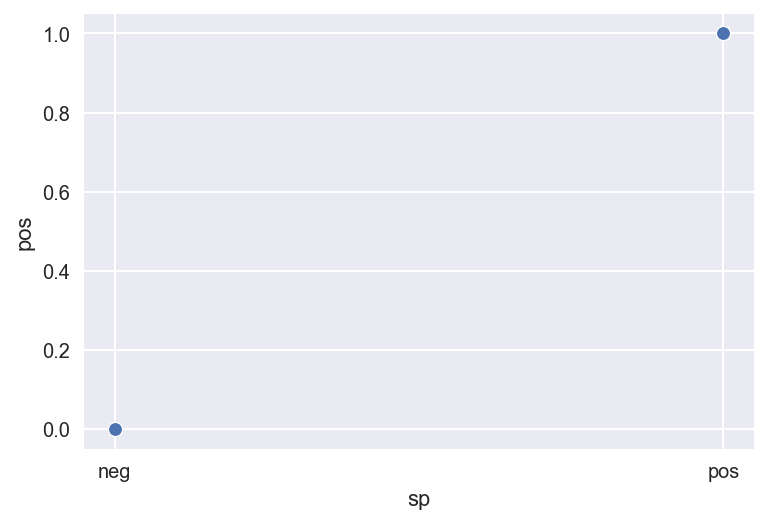

In [10]:
# check out 'sp' and 'pos' - seem to carry the same information, only in different formats
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_reviews, x="sp", y="pos")
plt.show();

Indeed that is the case. We will keep only the numerical one, 'pos'.

In [11]:
# check out the unique values in 'is_adult'
df_reviews['is_adult'].value_counts()

0    500
Name: is_adult, dtype: int64

There are only zeroes. We will drop the column.

In [12]:
# 'runtime_minutes' should all be numbers - check why it is an 'object' data type
df_reviews['runtime_minutes'].value_counts()

95     51
100    36
90     33
82     30
149    30
129    30
116    24
112    22
120    15
113    14
126    14
118    13
102    12
110    12
80     11
8      10
106    10
85     10
79      9
87      9
180     9
60      9
88      7
93      7
30      7
94      6
104     6
98      5
25      5
99      5
84      4
92      4
40      4
89      3
74      2
43      2
96      2
141     2
\N      2
130     2
44      2
97      2
121     2
70      1
45      1
78      1
123     1
107     1
109     1
Name: runtime_minutes, dtype: int64

'runtime_minutes' contains an illogical value, "\N", which is a value of 'end_year' and that seems to be the reason why its data type is 'object'. Load the data without doing data conversion on the fly then take care of the illogical values. 

* The bare minimum features required for the review classification task are:
<br>o 'review'
<br>o 'pos'

* It will be interesting to see if any of the following features will improve the model performance by providing more information or it will only confuse the model by contradicting the 'review':
<br>o 'runtime_minutes': if a film is too long, the chance of 'pos' being negative for a 'review' is higher?
<br>o 'genres': if a film is in one of the more popular 'genres', the chance of 'pos' being positive for a 'review' is higher?
<br>o 'rating', 'votes': if a film collected many 'votes' for a high 'rating', the chance of 'pos' being positive for a 'review' is higher?


* During the data loading, we will exclude the columns that do not provide information for the review classification task: 
<br>o 'title_type', 'primary_title', 'original_title', 'end_year'
<br>o 'average_rating': 'average_rating' is calculated from 'rating' and 'votes'. Either one has to go so as not to provoke  multicollinearity and to keep the model simple. The dataset was given to us already split into training and test sub-datasets, but it is quite possible that 'average_rating' was calculated prior to the split and its presence, therefore, could cause data leakage. We will remove 'average_rating' to be on the safe side. 
<br>o 'idx': the dataframe's native index will suffice. 


* We will separate the dataset into training and test sub-datasets according to the values in 'ds_part' later.
* 'start_year' does not help with the review classification task, but it will be interesting to see how the distribution of positive and negative reviews flucuated over the years, so we will load the data. 
* 'tconst' does not help with the review classification task either, but it is required in the graph plotting precode, so loading it in. 

* Convert the data types: 'genres': object to category; 'votes': object to Int64 (in the precode); 'ds_part': object to category

**Load the data file in full and drop the columns that are not informative while at it.**

In [13]:
wanted = ['review', 'pos', 'start_year', 'runtime_minutes', 'genres', 'rating', 'votes', 'ds_part', 'tconst']

try:
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'genres': 'category', 'ds_part': 'category'}, usecols=wanted)
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', usecols=wanted, dtype={'genres': 'category', 'ds_part': 'category'})

In [14]:
df_reviews.head()

,tconst,start_year,runtime_minutes,genres,votes,review,rating,pos,ds_part
0,tt0068152,1971,121,"Comedy,Crime,Drama",2218.0,The pakage implies that Warren Beatty and Gold...,1,0,train
1,tt0068152,1971,121,"Comedy,Crime,Drama",2218.0,How the hell did they get this made?! Presenti...,1,0,train
2,tt0313150,2002,25,"Comedy,Drama,Short",184.0,There is no real story the film seems more lik...,3,0,test
3,tt0313150,2002,25,"Comedy,Drama,Short",184.0,Um .... a serious film about troubled teens in...,7,1,test
4,tt0313150,2002,25,"Comedy,Drama,Short",184.0,I'm totally agree with GarryJohal from Singapo...,9,1,test


In [15]:
# check the shape of the dataframe
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   tconst           47331 non-null  object  
 1   start_year       47331 non-null  int64   
 2   runtime_minutes  47331 non-null  object  
 3   genres           47331 non-null  category
 4   votes            47329 non-null  float64 
 5   review           47331 non-null  object  
 6   rating           47331 non-null  int64   
 7   pos              47331 non-null  int64   
 8   ds_part          47331 non-null  category
dtypes: category(2), float64(1), int64(3), object(3)
memory usage: 2.7+ MB


<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The data was loaded and inspected!
	  
</div>

## EDA

**Drop the missing values.**

In [16]:
df_reviews.dropna(inplace=True) # 2 missing values dropped (only in 'votes')

**Drop the complete duplicates.**

In [17]:
df_reviews.duplicated().sum() 
df_reviews[df_reviews.duplicated(keep=False)].sort_values(by='review') # 85 complete duplicates dropped

,tconst,start_year,runtime_minutes,genres,votes,review,rating,pos,ds_part
33041,tt0145503,1999,181,"Drama,History,Romance",12788.0,"Back in his youth, the old man had wanted to ...",2,0,train
33040,tt0145503,1999,181,"Drama,History,Romance",12788.0,"Back in his youth, the old man had wanted to ...",2,0,train
36174,tt0082252,1981,100,"Documentary,History,Music",3448.0,"First of all, I reviewed this documentary bec...",10,1,test
36175,tt0082252,1981,100,"Documentary,History,Music",3448.0,"First of all, I reviewed this documentary bec...",10,1,test
36803,tt0436295,2005,83,Documentary,279.0,A friend and I went to see this movie. We have...,1,0,test
...,...,...,...,...,...,...,...,...,...
42050,tt0103007,1991,84,Comedy,5146.0,"in this movie, joe pesci slams dunks a basketb...",3,0,train
19312,tt0107302,1993,117,"Crime,Drama,Thriller",49857.0,it's amazing that so many people that i know h...,9,1,train
19315,tt0107302,1993,117,"Crime,Drama,Thriller",49857.0,it's amazing that so many people that i know h...,9,1,train
13770,tt0067118,1971,101,"Drama,Romance",829.0,"when I first heard about this movie, I noticed...",10,1,test


In [18]:
df_reviews.drop_duplicates(keep='first', inplace=True)

In [19]:
# handle "\N" in 'runtime_minutes'
proportion = (df_reviews[df_reviews['runtime_minutes']=="\\N"]).count()/df_reviews.shape[0]
proportion # 0.010288 - can afford to delete the rows

tconst             0.010287
start_year         0.010287
runtime_minutes    0.010287
genres             0.010287
votes              0.010287
review             0.010287
rating             0.010287
pos                0.010287
ds_part            0.010287
dtype: float64

In [20]:
# drop the rows where 'runtime_minutes' contains "\N"
df_reviews = df_reviews[df_reviews['runtime_minutes']!="\\N"]

In [21]:
# check the general statistics of the numerical features
df_reviews.describe()

,start_year,votes,rating,pos
count,46758.000000,4.675800e+04,46758.000000,46758.000000
mean,1989.520595,2.585203e+04,5.474700,0.497776
std,19.653711,8.413562e+04,3.468808,0.500000
min,1894.000000,9.000000e+00,1.000000,0.000000
25%,1982.000000,8.440000e+02,2.000000,0.000000
50%,1997.000000,3.275000e+03,4.000000,0.000000
75%,2004.000000,1.409900e+04,9.000000,1.000000
max,2010.000000,1.739448e+06,10.000000,1.000000


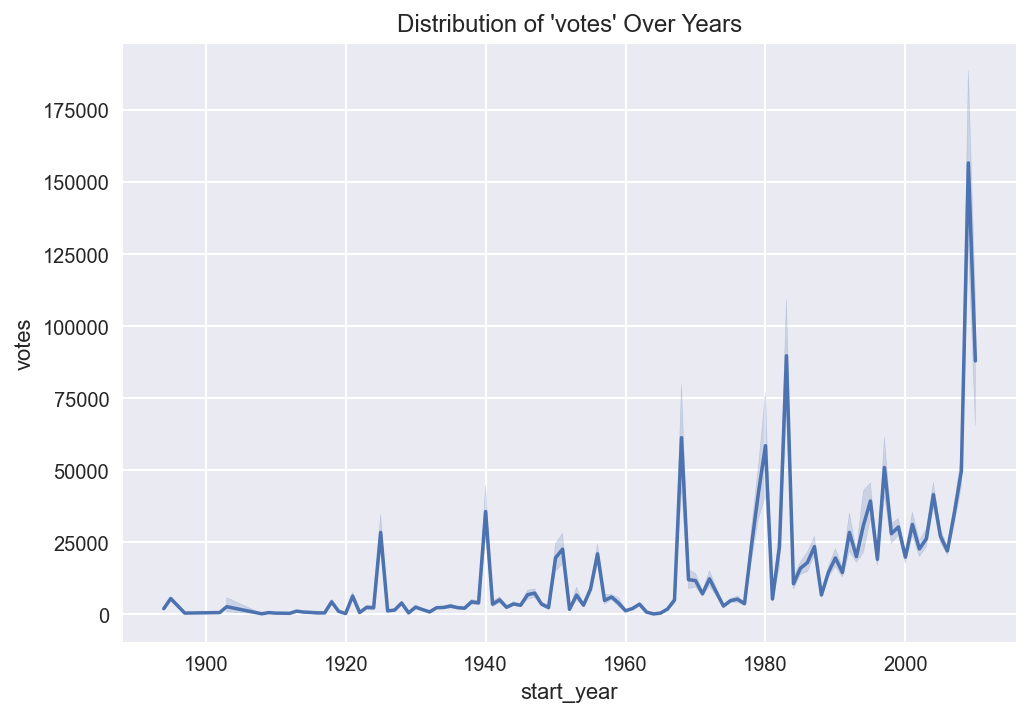

In [22]:
sns.lineplot(data=df_reviews, y='votes', x='start_year')
plt.title("Distribution of 'votes' Over Years")
plt.show();

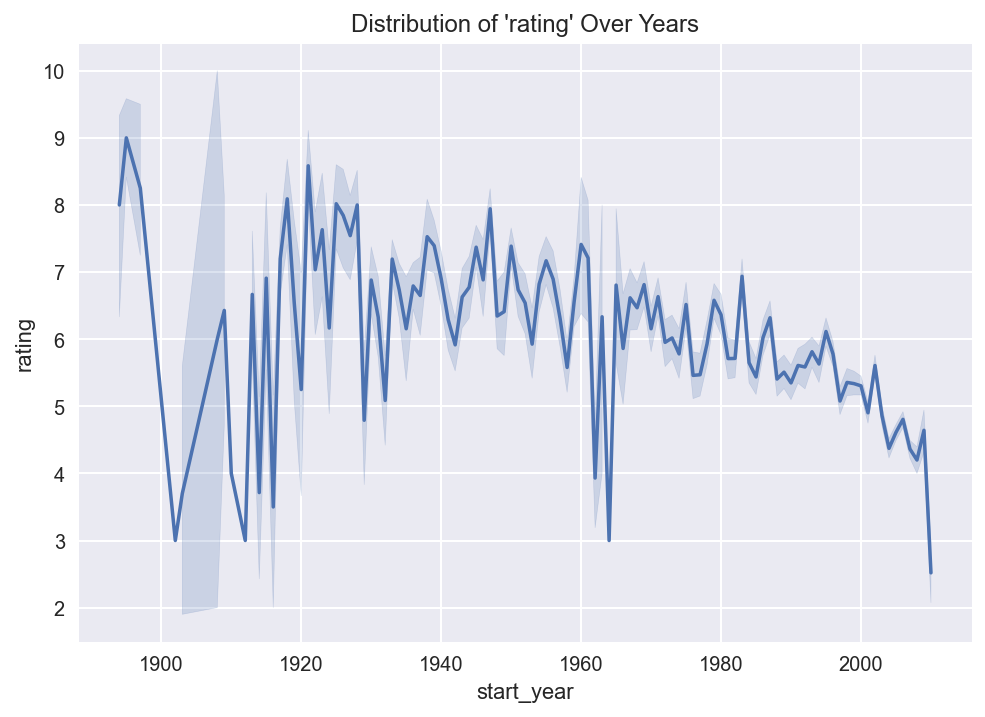

In [23]:
sns.lineplot(data=df_reviews, y='rating', x='start_year')
plt.title("Distribution of 'rating' Over Years")
plt.show();

The confidence interval can be seen as the area around the line itself, which is the estimated central tendency of our data. Since we have multiple y values for each x value (many votes in each year), Seaborn calculates the central tendency of these records and plots that line, as well as a confidence interval for that tendency.

The concept of "outliers" does not come in here. 

In [24]:
# look at the target variable.
df_reviews['pos'].value_counts() 

0    23483
1    23275
Name: pos, dtype: int64

No class imbalance.

Let's check the number of movies and reviews over years. (precode)

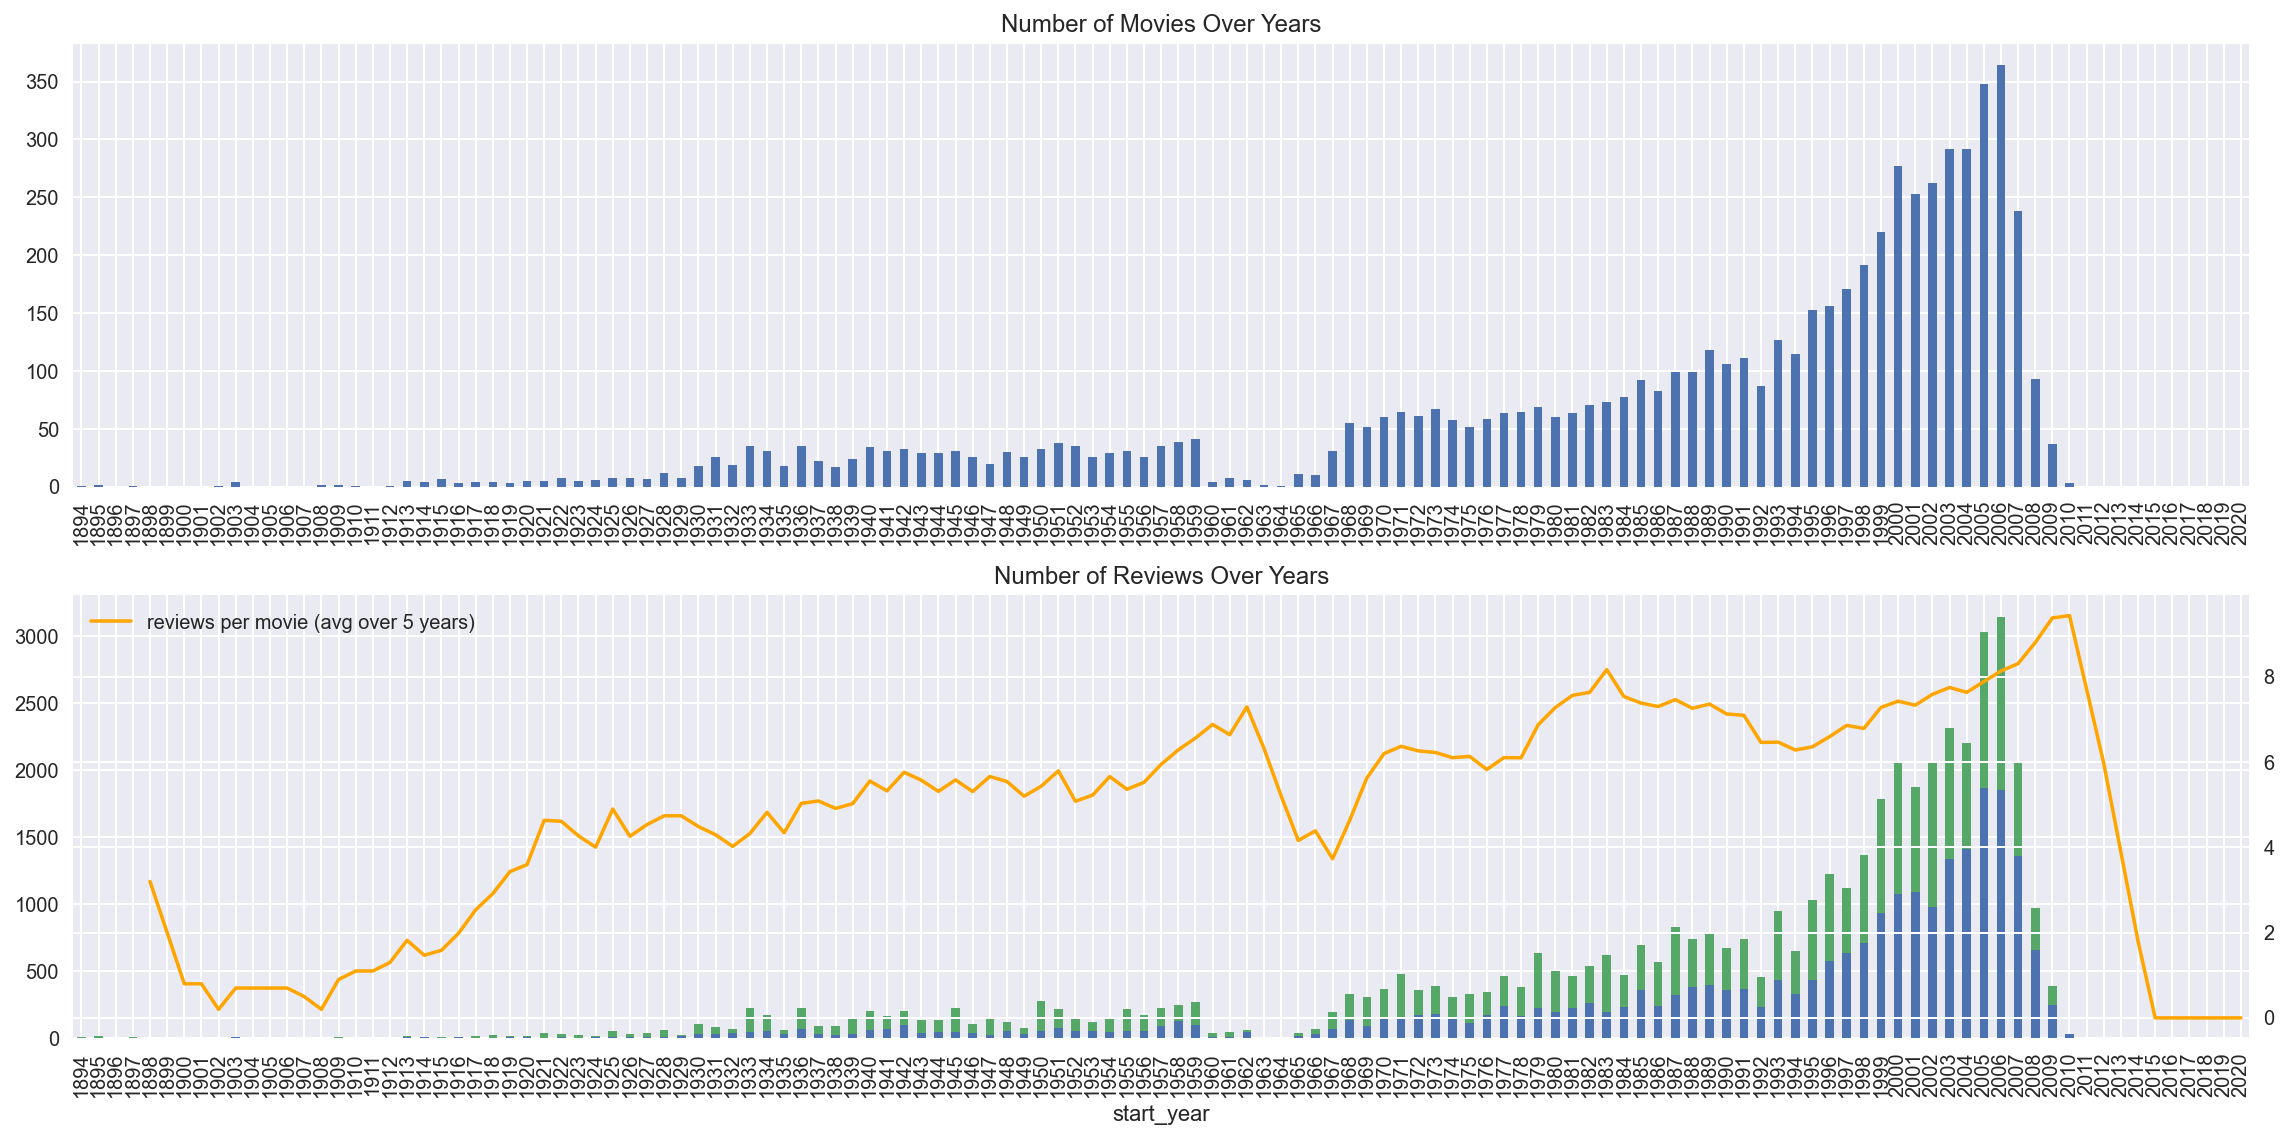

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

* The number of movies released suddenly drops in 1960 and stays rock-bottom until 1966, after which it starts picking up. This is the period of the Vietnam War, the civil rights movement, the flower power - the audience's taste completely changed, aging studio executives were disconnected from their target clientele and the Hollywood’s Golden Age came to an end. 
* The number of movies released started increasing from 1985 and peaked in 2006. It, however, has been on a decline ever since. 

* Apart from the dip between 1960 and 1966, the number of reviews is fairly stable over the history of cinema. 

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting). (precode)

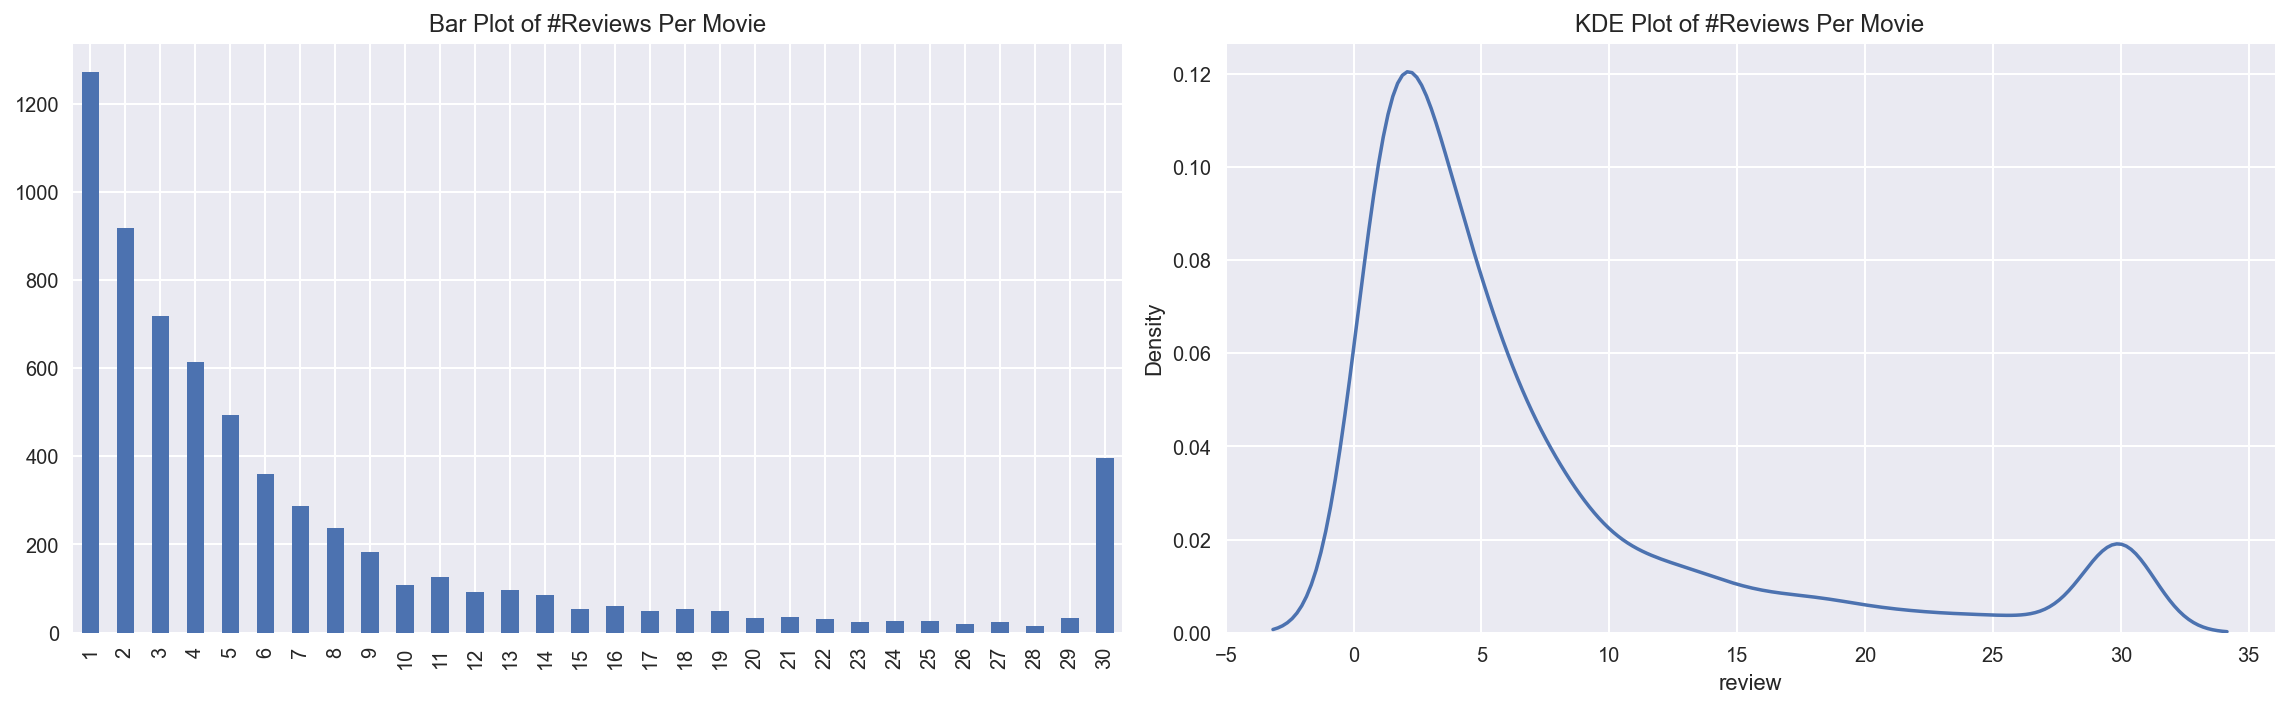

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The number of reviews is not equal for all the movies. 

Most movies receive only one review. 

Let's check the distribution of the positive and negative ratings in the training and test datasets. (precode)

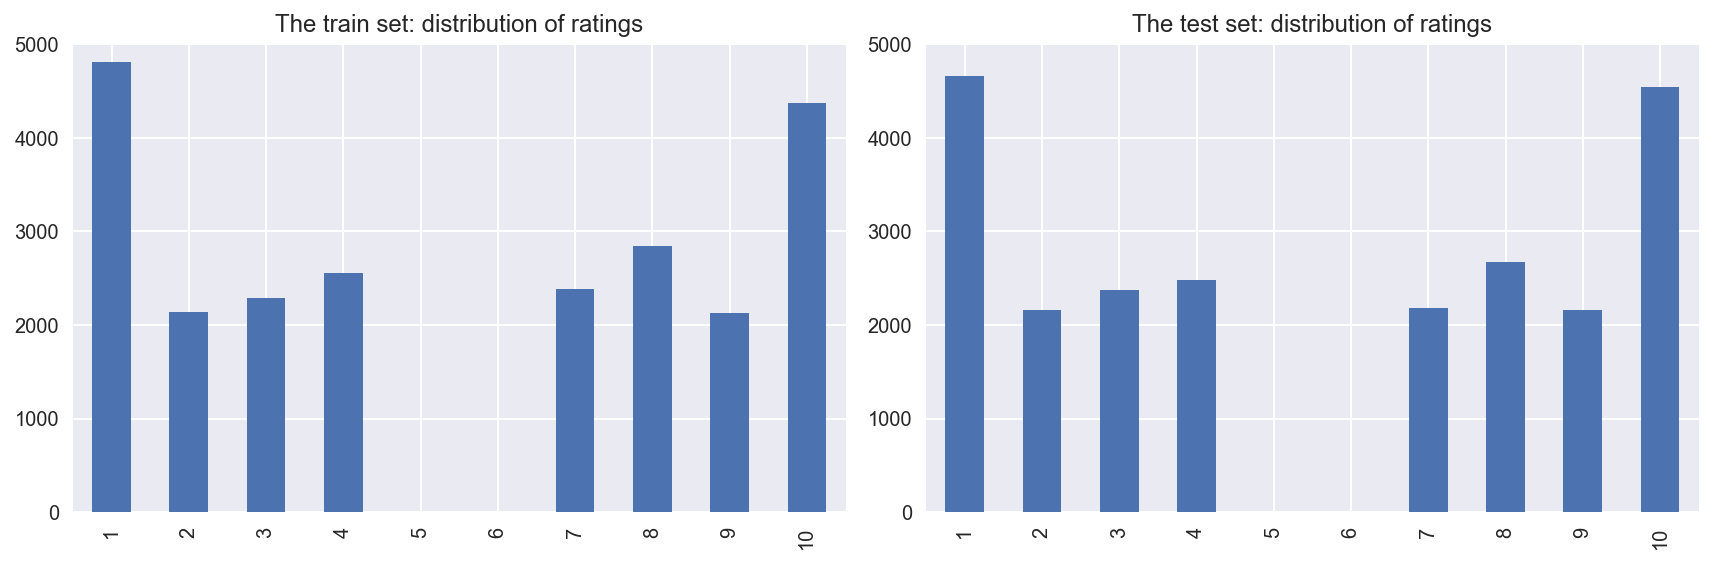

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

The training and test datasets share a very similar distribution. 

Let's check the distribution of negative and positive reviews over the years for two parts of the dataset. (precode)

C:\Users\renab\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\renab\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\renab\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\renab\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


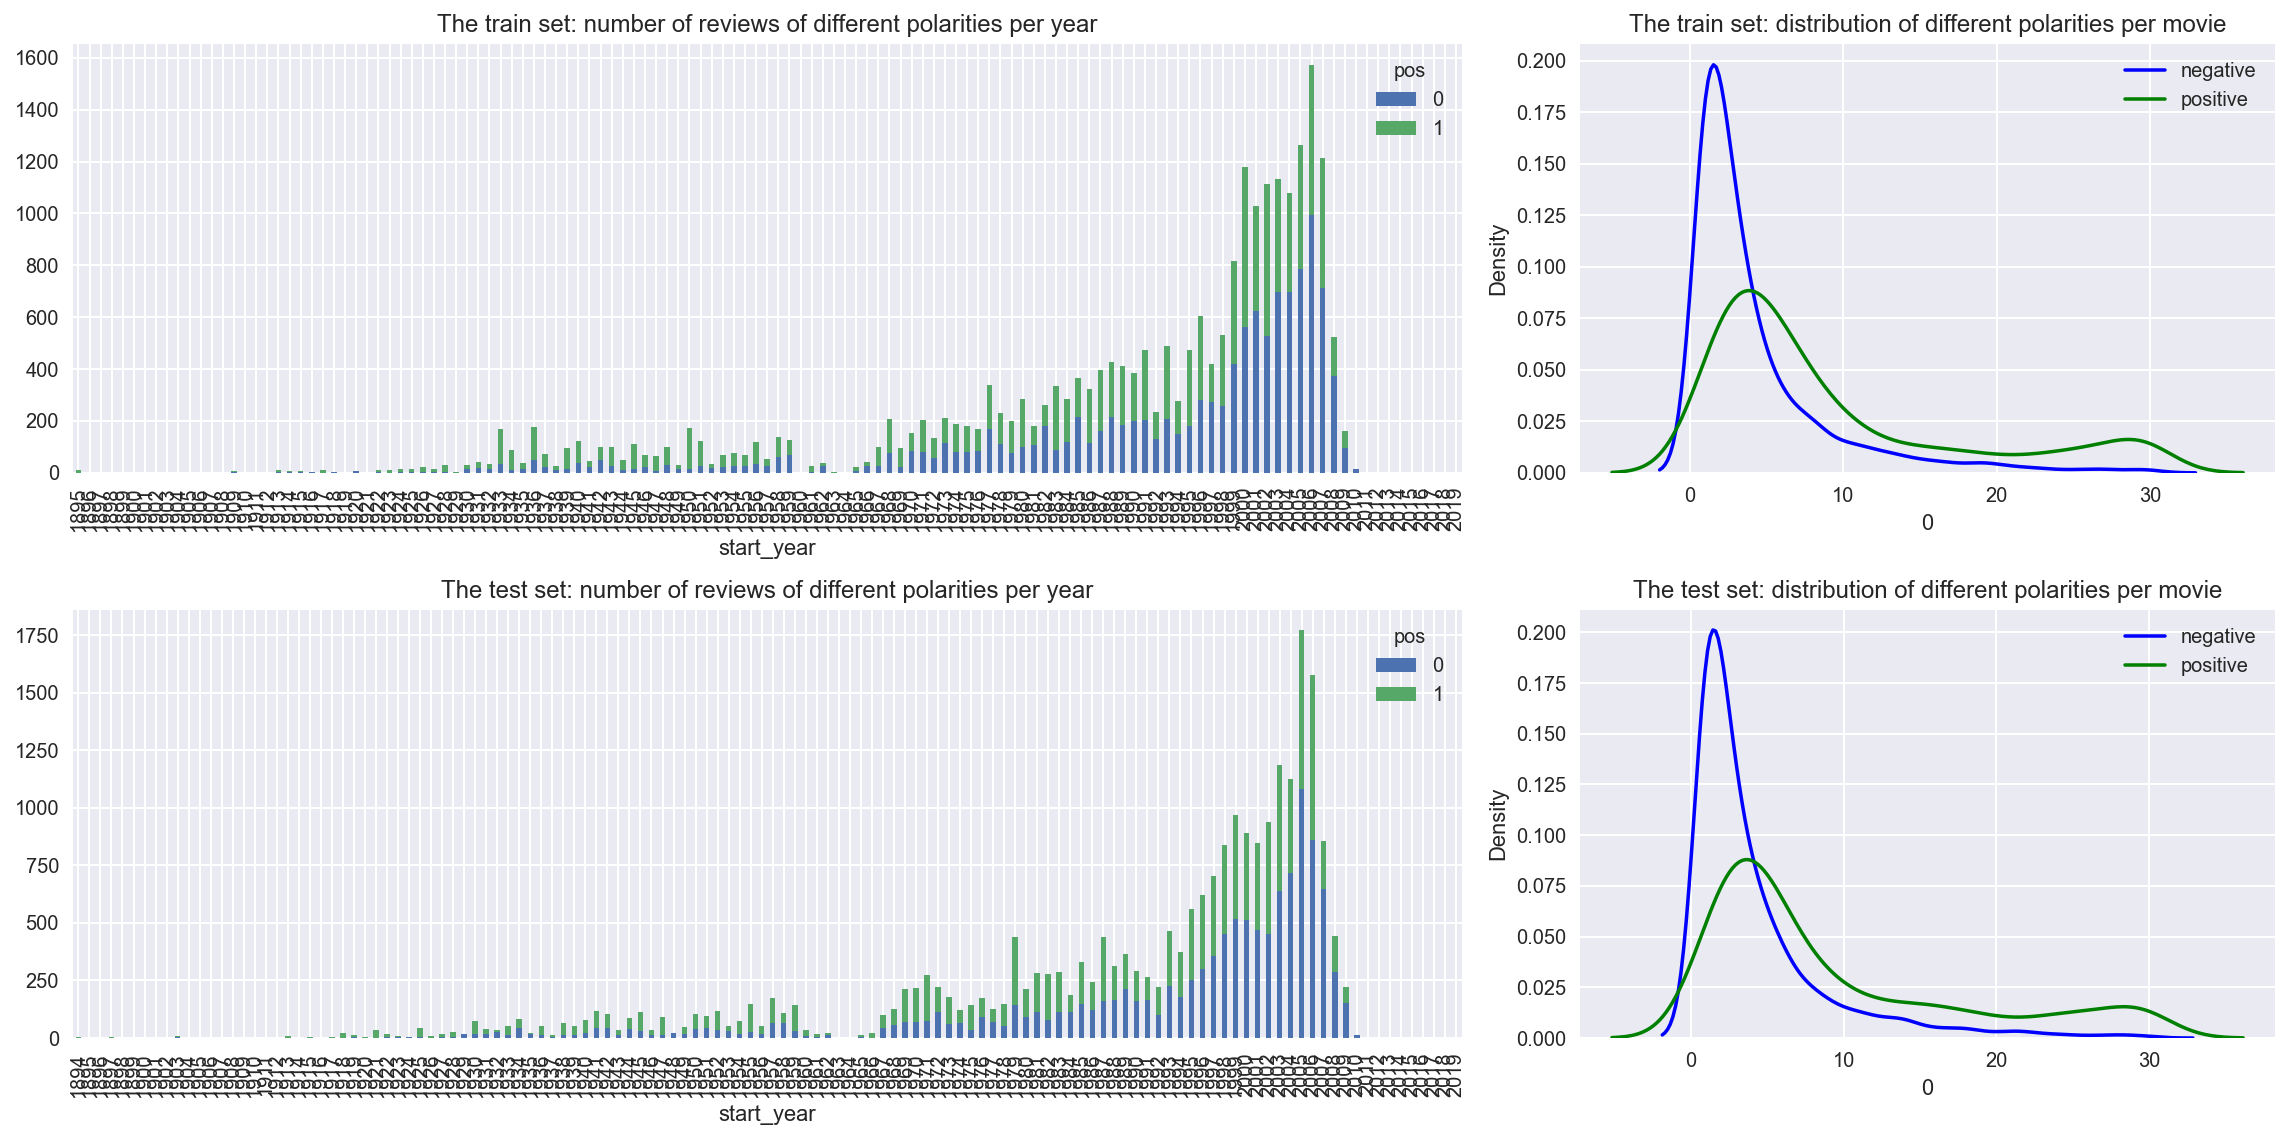

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The training and test datasets share a very similar distribution. 

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Great, you explored the data and made some interesting observations!
	  
</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [29]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [30]:
import re

def clear_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text).lower()
    return " ".join(text.split())

In [31]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: clear_text(x))
df_reviews['genres_norm'] = df_reviews['genres'].apply(lambda x: clear_text(x))

# verify it worked
df_reviews.head()

,tconst,start_year,runtime_minutes,genres,votes,review,rating,pos,ds_part,review_norm,genres_norm
0,tt0068152,1971,121,"Comedy,Crime,Drama",2218.0,The pakage implies that Warren Beatty and Gold...,1,0,train,the pakage implies that warren beatty and gold...,comedy crime drama
1,tt0068152,1971,121,"Comedy,Crime,Drama",2218.0,How the hell did they get this made?! Presenti...,1,0,train,how the hell did they get this made presenting...,comedy crime drama
2,tt0313150,2002,25,"Comedy,Drama,Short",184.0,There is no real story the film seems more lik...,3,0,test,there is no real story the film seems more lik...,comedy drama short
3,tt0313150,2002,25,"Comedy,Drama,Short",184.0,Um .... a serious film about troubled teens in...,7,1,test,um a serious film about troubled teens in sing...,comedy drama short
4,tt0313150,2002,25,"Comedy,Drama,Short",184.0,I'm totally agree with GarryJohal from Singapo...,9,1,test,i'm totally agree with garryjohal from singapo...,comedy drama short


<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Normalization looks good!
	  
</div>

Lemmatised using NLTK.

In [32]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer  = WordNetLemmatizer() 

In [33]:
def lemmatize_nlp(text):       
    tokens = word_tokenize(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    return (" ".join(lemmas))

In [34]:
import time

In [35]:
start = time.time()
print("Start lemmatizing at", start)

# silence SettingWithCopyWarning that may arise
pd.options.mode.chained_assignment = None

df_reviews['review_nltk'] = df_reviews['review_norm'].apply(lambda x: lemmatize_nlp(x))
df_reviews['genres_nltk'] = df_reviews['genres_norm'].apply(lambda x: lemmatize_nlp(x))

end = time.time()
print("Ending lemmatization at", end)
print(end - start, 's')

Start lemmatizing at 1637088788.4702442
Ending lemmatization at 1637088914.648671
126.17842674255371 s


In [36]:
df_reviews.head()

,tconst,start_year,runtime_minutes,genres,votes,review,rating,pos,ds_part,review_norm,genres_norm,review_nltk,genres_nltk
0,tt0068152,1971,121,"Comedy,Crime,Drama",2218.0,The pakage implies that Warren Beatty and Gold...,1,0,train,the pakage implies that warren beatty and gold...,comedy crime drama,the pakage implies that warren beatty and gold...,comedy crime drama
1,tt0068152,1971,121,"Comedy,Crime,Drama",2218.0,How the hell did they get this made?! Presenti...,1,0,train,how the hell did they get this made presenting...,comedy crime drama,how the hell did they get this made presenting...,comedy crime drama
2,tt0313150,2002,25,"Comedy,Drama,Short",184.0,There is no real story the film seems more lik...,3,0,test,there is no real story the film seems more lik...,comedy drama short,there is no real story the film seems more lik...,comedy drama short
3,tt0313150,2002,25,"Comedy,Drama,Short",184.0,Um .... a serious film about troubled teens in...,7,1,test,um a serious film about troubled teens in sing...,comedy drama short,um a serious film about troubled teen in singa...,comedy drama short
4,tt0313150,2002,25,"Comedy,Drama,Short",184.0,I'm totally agree with GarryJohal from Singapo...,9,1,test,i'm totally agree with garryjohal from singapo...,comedy drama short,i 'm totally agree with garryjohal from singap...,comedy drama short


Lemmatised using spaCy.

In [37]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [38]:
def lemmatize_spacy(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [39]:
start = time.time()
print("Start lemmatizing at", start)

# silence SettingWithCopyWarning that may arise
pd.options.mode.chained_assignment = None

df_reviews['review_spacy'] = df_reviews['review_norm'].apply(lambda x: lemmatize_spacy(x))
df_reviews['genres_spacy'] = df_reviews['genres_norm'].apply(lambda x: lemmatize_spacy(x))

end = time.time()
print("Ending lemmatization at", end)
print(end - start, 's')

Start lemmatizing at 1637088942.9347467
Ending lemmatization at 1637090046.119536
1103.1847891807556 s


In [40]:
df_reviews.head()

,tconst,start_year,runtime_minutes,genres,votes,review,rating,pos,ds_part,review_norm,genres_norm,review_nltk,genres_nltk,review_spacy,genres_spacy
0,tt0068152,1971,121,"Comedy,Crime,Drama",2218.0,The pakage implies that Warren Beatty and Gold...,1,0,train,the pakage implies that warren beatty and gold...,comedy crime drama,the pakage implies that warren beatty and gold...,comedy crime drama,the pakage imply that warren beatty and goldie...,comedy crime drama
1,tt0068152,1971,121,"Comedy,Crime,Drama",2218.0,How the hell did they get this made?! Presenti...,1,0,train,how the hell did they get this made presenting...,comedy crime drama,how the hell did they get this made presenting...,comedy crime drama,how the hell do they get this make present its...,comedy crime drama
2,tt0313150,2002,25,"Comedy,Drama,Short",184.0,There is no real story the film seems more lik...,3,0,test,there is no real story the film seems more lik...,comedy drama short,there is no real story the film seems more lik...,comedy drama short,there be no real story the film seem more like...,comedy drama short
3,tt0313150,2002,25,"Comedy,Drama,Short",184.0,Um .... a serious film about troubled teens in...,7,1,test,um a serious film about troubled teens in sing...,comedy drama short,um a serious film about troubled teen in singa...,comedy drama short,um a serious film about troubled teen in singa...,comedy drama short
4,tt0313150,2002,25,"Comedy,Drama,Short",184.0,I'm totally agree with GarryJohal from Singapo...,9,1,test,i'm totally agree with garryjohal from singapo...,comedy drama short,i 'm totally agree with garryjohal from singap...,comedy drama short,I be totally agree with garryjohal from singap...,comedy drama short


Prepared two 'review' columns, one lemmatised with NLTK and another with SpaCy so we can compare. spaCy takes nine times as long to process the same volume of corpus than NLTK.


Note: I had originally added a tqdm progress bar but it slowed down the lemmatization operation tremendously, so I removed it. 

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Great, you applied lemmatization using NLTK and spacy!
	  
</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [41]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23516, 15)
(23242, 15)


In [42]:
df_reviews_train.head()

,tconst,start_year,runtime_minutes,genres,votes,review,rating,pos,ds_part,review_norm,genres_norm,review_nltk,genres_nltk,review_spacy,genres_spacy
0,tt0068152,1971,121,"Comedy,Crime,Drama",2218.0,The pakage implies that Warren Beatty and Gold...,1,0,train,the pakage implies that warren beatty and gold...,comedy crime drama,the pakage implies that warren beatty and gold...,comedy crime drama,the pakage imply that warren beatty and goldie...,comedy crime drama
1,tt0068152,1971,121,"Comedy,Crime,Drama",2218.0,How the hell did they get this made?! Presenti...,1,0,train,how the hell did they get this made presenting...,comedy crime drama,how the hell did they get this made presenting...,comedy crime drama,how the hell do they get this make present its...,comedy crime drama
7,tt0035958,1943,88,"Drama,History,War",1240.0,This true story of Carlson's Raiders is more o...,2,0,train,this true story of carlson's raiders is more o...,drama history war,this true story of carlson 's raider is more o...,drama history war,this true story of carlson 's raider be more o...,drama history war
8,tt0035958,1943,88,"Drama,History,War",1240.0,Should have been titled 'Balderdash!' Little i...,2,0,train,should have been titled 'balderdash ' little i...,drama history war,should have been titled 'balderdash ' little i...,drama history war,should have be title ' balderdash ' little in ...,drama history war
9,tt0035958,1943,88,"Drama,History,War",1240.0,The movie 'Gung Ho!': The Story of Carlson's M...,4,0,train,the movie 'gung ho ' the story of carlson's ma...,drama history war,the movie 'gung ho ' the story of carlson 's m...,drama history war,the movie ' gung ho ' the story of carlson 's ...,drama history war


Prepare datasets with columns lemmatised using NLTK.

Dataset (A-NLTK) Bare-minimum dataset ('review_norm' only)

In [43]:
X_train_min = df_reviews_train[['review_nltk']] # (23516, 1); train_target (23516,)
X_test_min = df_reviews_test[['review_nltk']] # (23242, 1); test_target (23242,)

Dataset (B-NLTK) Add 'runtime_minutes', 'votes' and 'rating'

In [44]:
X_train_add1 = df_reviews_train[['review_nltk', 'runtime_minutes', 'votes', 'rating']] # (23516, 4); train_target (23516,)
X_test_add1 = df_reviews_test[['review_nltk', 'runtime_minutes', 'votes', 'rating']] # (23242, 4); test_target (23242,)

Dataset (C-NLTK) Add 'genres'

In [45]:
X_train_add2 = df_reviews_train[['review_nltk', 'runtime_minutes', 'votes', 'rating', 'genres_nltk']]
X_test_add2 = df_reviews_test[['review_nltk', 'runtime_minutes', 'votes', 'rating', 'genres_nltk']]

Prepare datasets with columns lemmatised using spaCy.

Dataset (A-spaCy) Bare-minimum dataset ('review_norm' only)

In [46]:
X_train_min_spacy = df_reviews_train[['review_spacy']] # (23516, 1); train_target (23516,)
X_test_min_spacy = df_reviews_test[['review_spacy']] # (23242, 1); test_target (23242,)

Dataset (B-spaCy) Add 'runtime_minutes', 'votes' and 'rating'

In [47]:
X_train_add1_spacy = df_reviews_train[['review_spacy', 'runtime_minutes', 'votes', 'rating']] # (23516, 4); train_target (23516,)
X_test_add1_spacy = df_reviews_test[['review_spacy', 'runtime_minutes', 'votes', 'rating']] # (23242, 4); test_target (23242,)

Dataset (C-spaCy) Add 'genres'

In [48]:
X_train_add2_spacy = df_reviews_train[['review_spacy', 'runtime_minutes', 'votes', 'rating', 'genres_spacy']]
X_test_add2_spacy = df_reviews_test[['review_spacy', 'runtime_minutes', 'votes', 'rating', 'genres_spacy']]

Prepared the datasets for comparing the lemmatization methods.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Ok, it will be interesting to compare the models' performance on these datasets!
	  
</div>

## Working with models

We will try classification models based on logistic regression and gradient boosting.



### Model 0 - Constant

In [49]:
from sklearn.dummy import DummyClassifier

In [50]:
dc_model = DummyClassifier(strategy='uniform', random_state=12345) 
dc_model.fit(X_train_min, train_target)
y_pred = dc_model.predict(X_test_min)
#evaluate_model(dc_model, X_train_min, train_target, X_test_min, test_target)
f1_score(test_target, y_pred) # 0.49755091518432587

0.49755091518432587

The models are expected to score at least this much.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
There's a baseline!
	  
</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

We will check the performance of a logistic regression model with the following settings:

* Dataset (A-NLTK) with 'review_norm' only
<br>o Without bigrams
<br>o With bigrams


* Dataset (B-NLTK) with 'review_norm', 'runtime_minutes', 'votes' and 'rating'
<br>o Without bigrams
<br>o With bigrams


* Dataset (C-NLTK) with 'review_norm', 'runtime_minutes', 'votes', 'rating', and 'genres'
<br>o Without bigrams
<br>o With bigrams

In [53]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

Remove stop words.

In [54]:
from sklearn.compose import ColumnTransformer

In [ ]:
# remove stop words from the texts, vectorise them, and calculate TF-IDF on them
stop_words = set(stopwords.words('english'))

In [60]:
# without biggrams
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)

# with bigrams
#tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2))

In [61]:
# dataset (A-NLTK)
tfidf_vectorizer_1.fit(X_train_min['review_nltk']) 

# dataset (B-NLTK)
#tfidf_vectorizer_1.fit(X_train_add1['review_nltk']) 

# dataset (C-NLTK)
#ct_1 = ColumnTransformer([(x, TfidfVectorizer(stop_words=stop_words), x) for x in ['review_nltk', 'genres_nltk']]) # without bigrams
#ct_1 = ColumnTransformer([(x, TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2)), x) for x in ['review_nltk', 'genres_nltk']]) # with bigrams

#ct_1.fit(X_train_add2)

TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [62]:
# dataset (A-NLTK): (23516, 63902) without bigrams; (23516, 1683865) with bigrams
tf_idf_train = tfidf_vectorizer_1.transform(X_train_min['review_nltk']) 

# dataset (B-NLTK): (23516, 63902) without bigrams; (23516, 1683865) with bigrams
#tf_idf_train = tfidf_vectorizer_1.transform(X_train_add1['review_nltk']) 

# dataset (C-NLTK): (23516, 71138) without bigrams; (23516, 1579794) with bigrams
#tf_idf_train = ct_1.transform(X_train_add2) 

tf_idf_train.shape

(23516, 63902)

In [63]:
# dataset (A-NLTK): (23242, 63902) without bigrams; (23242, 1683865) with bigrams
tf_idf_test = tfidf_vectorizer_1.transform(X_test_min['review_nltk']) 

# dataset (B-NLTK): (23242, 63902) without bigrams; (23242, 1683865) with bigrams 
#tf_idf_test = tfidf_vectorizer_1.transform(X_test_add1['review_nltk']) 

# dataset (C-NLTK): (23242, 71138) without bigrams; (23242, 1579794) with bigrams
#tf_idf_test = ct_1.transform(X_test_add2) 

tf_idf_test.shape

(23242, 63902)

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


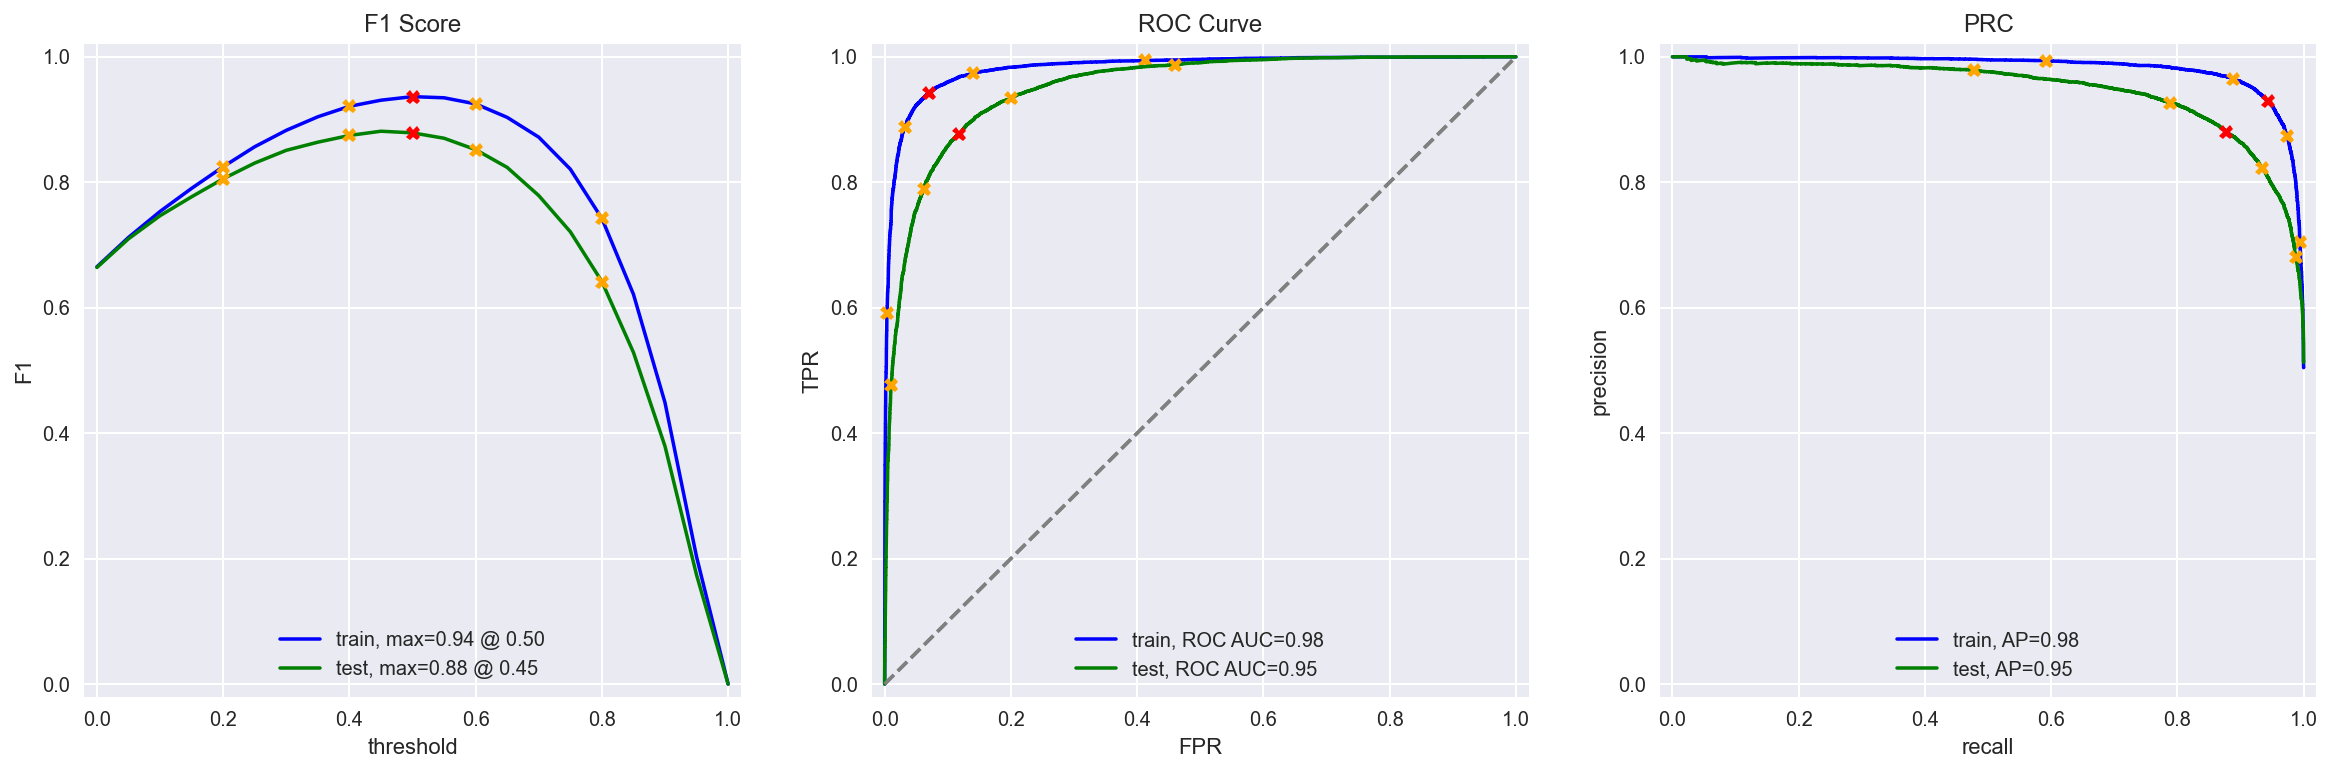

In [64]:
from sklearn.model_selection import cross_val_score
import numpy as np

# create a logitic regression model
model_1 = LogisticRegression(random_state=12345, solver='liblinear') 
scores = cross_val_score(model_1, tf_idf_train, train_target, cv=5, scoring='f1')

# fit the model 
model_1.fit(tf_idf_train, train_target) 

# check the prediction performance
evaluate_model(model_1, tf_idf_train, train_target, tf_idf_test, test_target) 

* Without bigrams

| 		| 	Training	 | 		 | 		 | 		 | 	Test	 | 		 | 		 | 		 | 
|---		| 		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 		| 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 | 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 | 
|---		| 		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 	Dataset A-NLTK	| 	0.94	 | 	0.94	 | 	0.98	 | 	0.98	 | 	0.88	 | 	0.88	 | 	0.95	 | 	0.95	 | 
| 	Dataset B-NLTK	| 	0.94	 | 	0.94	 | 	0.98	 | 	0.98	 |	0.88	 |	0.88	 |	0.95	 |	0.95	 |
| 	Dataset C-NLTK	| 	0.94	 | 	0.94	 | 	0.98	 | 	0.98	 |	0.88	 |	0.88	 |	0.95	 |	0.95	 |



* With bigrams

| 		| 	Training	 | 		 | 		 | 		| 	Test	 | 		 | 		 | 		 |
|---		|---		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 		| 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	| 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 |
|---		|---		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 	Dataset A-NLTK	| 	1.00	 | 	1.00	 | 	1.00	 | 	1.00	 |	0.84	 |	0.84	 |	0.91	 |	0.92	 |
| 	Dataset B-NLTK	| 	1.00	 | 	1.00	 | 	1.00	 | 	1.00	 |	0.84	 |	0.84	 |	0.91	 |	0.92	 |
| 	Dataset C-NLTK	| 	0.94	 | 	0.94	 | 	0.98	 | 	0.98	 |	0.77	 |	0.77	 |	0.83	 |	0.84	 |

### Model 3 - spaCy, TF-IDF and LR

TF-IDF

We will check the performance of a logistic regression model with the following settings:

* Dataset (A-spaCy) with 'review_norm' only
<br>o Without bigrams
<br>o With bigrams


* Dataset (B-spaCy) with 'review_norm', 'runtime_minutes', 'votes' and 'rating'
<br>o Without bigrams
<br>o With bigrams


* Dataset (C-spaCy) with 'review_norm', 'runtime_minutes', 'votes', 'rating', and 'genres'
<br>o Without bigrams
<br>o With bigrams

Remove stop words.

In [93]:
# without biggrams
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

# with bigrams
#tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2))

In [94]:
# dataset (A-spaCy)
tfidf_vectorizer_3.fit(X_train_min_spacy['review_spacy']) 

# dataset (B-spaCy)
#tfidf_vectorizer_3.fit(X_train_add1_spacy['review_spacy']) 

# dataset (C-spaCy)
#ct_3 = ColumnTransformer([(x, TfidfVectorizer(stop_words=stop_words), x) for x in ['review_spacy', 'genres_spacy']]) # without bigrams
#ct_3 = ColumnTransformer([(x, TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2)), x) for x in ['review_spacy', 'genres_spacy']]) # with bigrams
#ct_3.fit(X_train_add2_spacy)

TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [95]:
# dataset (A-spaCy): (23516, 58763) without bigrams; (23516, 1470291) with bigrams
tf_idf_train_spacy = tfidf_vectorizer_3.transform(X_train_min_spacy['review_spacy']) 

# dataset (B-spaCy): (23516, 58763) without bigrams; (23516, 1470291) with bigrams
#tf_idf_train_spacy = tfidf_vectorizer_3.transform(X_train_add1_spacy['review_spacy']) 

# dataset (C-spaCy): (23516, 58795) without bigrams; (23516, 1470490) with bigrams
#tf_idf_train_spacy = ct_3.transform(X_train_add2_spacy) 

tf_idf_train_spacy.shape

(23516, 58763)

In [96]:
# dataset (A-spaC-spaCyy: (23242, 58763) without bigrams; (23242, 1470291) with bigrams
tf_idf_test_spacy = tfidf_vectorizer_3.transform(X_test_min_spacy['review_spacy']) 

# dataset (B-spaCy): (23242, 58763) without bigrams; (23242, 1470291) with bigrams 
#tf_idf_test_spacy = tfidf_vectorizer_3.transform(X_test_add1_spacy['review_spacy']) 

# dataset (C-spaCy): (23242, 58795) without bigrams; (23242, 1470490) with bigrams
#tf_idf_test_spacy = ct_3.transform(X_test_add2_spacy) 

tf_idf_test_spacy.shape

(23242, 58763)

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


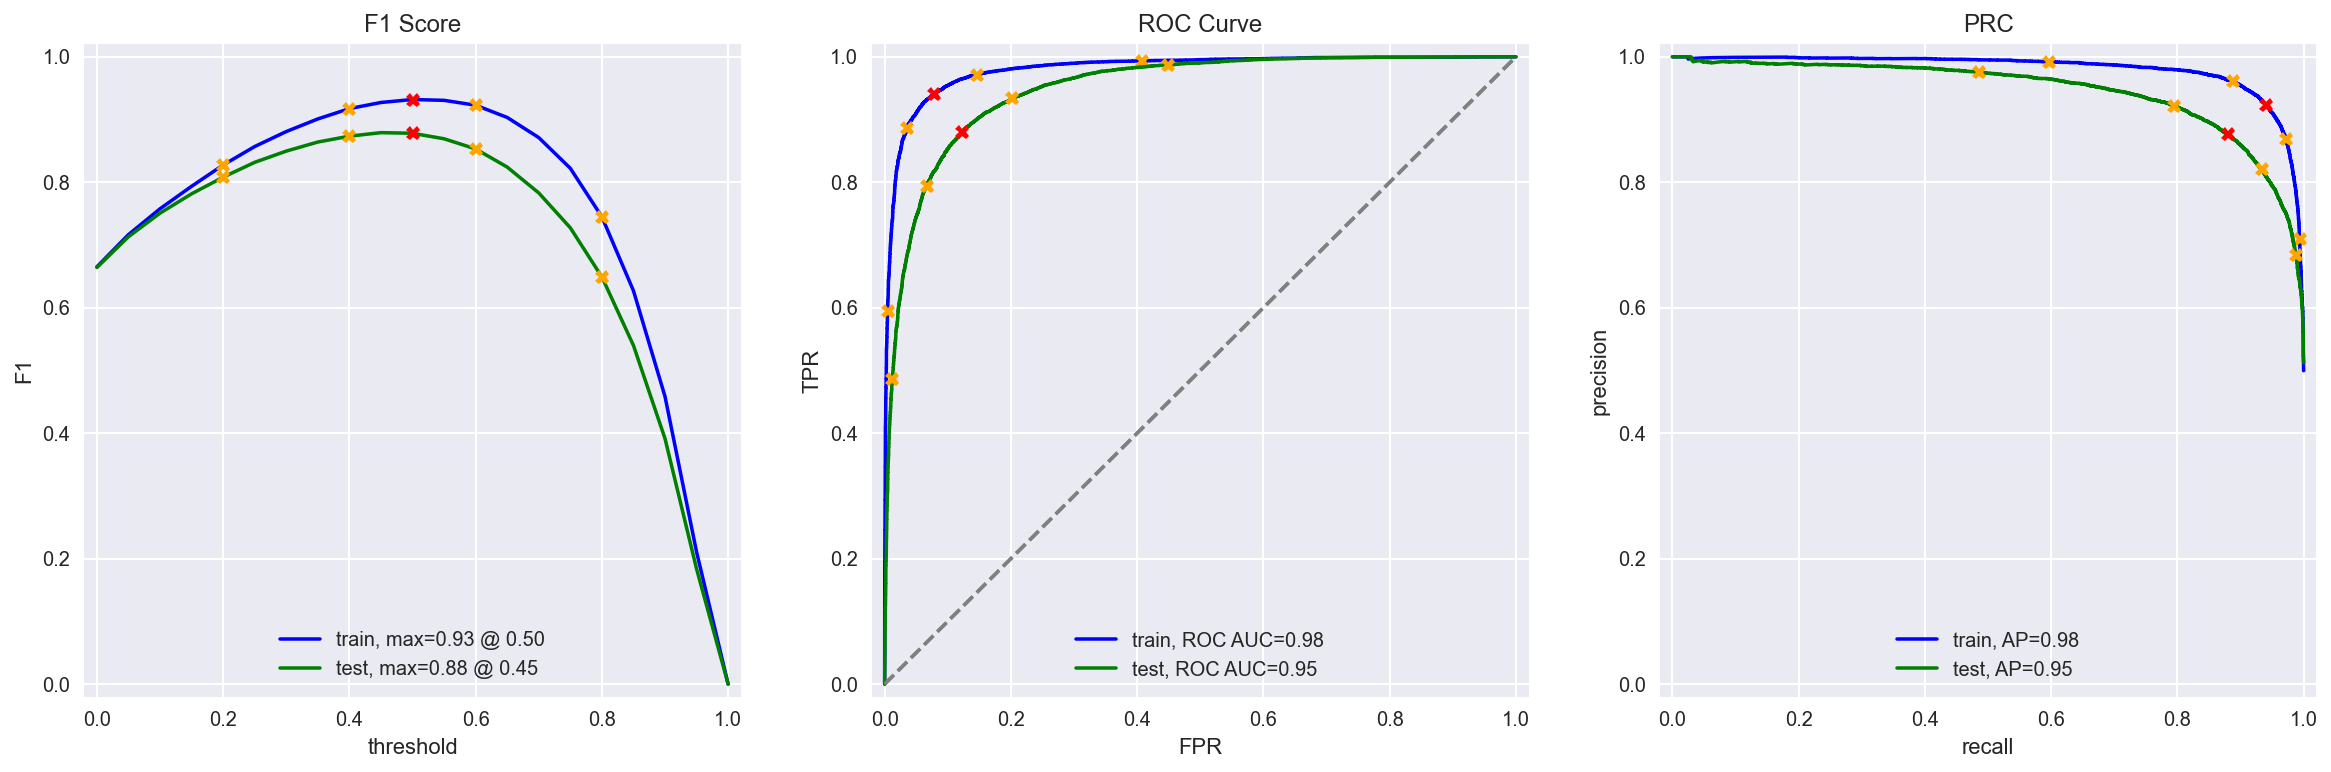

In [97]:
# create a logistic regression model

model_3 = LogisticRegression(random_state=12345, solver='liblinear') 
scores = cross_val_score(model_3, tf_idf_train_spacy, train_target, cv=5, scoring='f1')

# fit the model 
model_3.fit(tf_idf_train_spacy, train_target) 

# check the prediction performance
evaluate_model(model_3, tf_idf_train_spacy, train_target, tf_idf_test_spacy, test_target) 

* Without bigrams

| 		| 	Training	 | 		 | 		 | 		 | 	Test	 | 		 | 		 | 		 | 
|---		| 		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 		| 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 | 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 | 
|---		| 		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 	Dataset A-spaCy	| 	0.93	 | 	0.93	 | 	0.98	 | 	0.98	 | 	0.88	 | 	0.88	 | 	0.95	 | 	0.95	 | 
| 	Dataset B-spaCy	| 	0.93	 | 	0.93	 | 	0.98	 | 	0.98	 |	0.88	 |	0.88	 |	0.95	 |	0.95	 |
| 	Dataset C-spaCy	| 	0.93	 | 	0.93	 | 	0.98	 | 	0.98	 |	0.87	 |	0.87	 |	0.94	 |	0.95	 |


* With bigrams

| 		| 	Training	 | 		 | 		 | 		| 	Test	 | 		 | 		 | 		 |
|---		|---		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 		| 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	| 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 |
|---		|---		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 	Dataset A-spaCy	| 	0.99	 | 	0.99	 | 	1.00	 | 	1.00	 |	0.84	 |	0.84	 |	0.91	 |	0.92	 |
| 	Dataset B-spaCy	| 	0.99	 | 	0.99	 | 	1.00	 | 	1.00	 |	0.84	 |	0.84	 |	0.91	 |	0.92	 |
| 	Dataset C-spaCy	| 	0.94	 | 	0.94	 | 	0.98	 | 	0.98	 |	0.77	 |	0.77	 |	0.83	 |	0.84	 |


* Without bigrams
<br>NLTK produced a more stable set of scores than spaCy where the difference between the training outcome and the test outcome was smaller.
<br>o NLTK scored higher than spaCy on the training dataset.
<br>o NLTK and spaCy scored the same on the test dataset.
<br>o Adding 'genres' had no effect on the NLTK score but decreased the spaCy score.


* With bigrams
<br>NLTK produced a less stable set of scores than spaCy where the difference between the training outcome and the test outcome was greater.
<br>o NLTK scored higher than spaCy on the training dataset.
<br>o NLTK and spaCy scored the same on the test dataset.
<br>o Adding 'genres' had no effect on NLTK or spaCy.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Excellent, TF-IDF was applied to vectorize the text data correctly. It's nice that you tried incorporating bigrams!
	  
</div>

**Addendum - Dataset (D-F with NLTK) 'review_norm' truncated to median length**

Let us see if shortening the text length in 'review' will improve the model performance in any way. 

We will create a column of 'review' of a fixed median length of up to 176 tokens:

D) counting from the last token since review writers tend to write the conclusion at the end of the paragraph. The tokens at the beginning of reviews longer than 176 are dropped.
<br>E) counting from the first token
<br>F) taking from the middle, i.e. 176/2 = 88 tokens from either side of the token in the middle. 

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Interesting idea!
	  
</div>

In [74]:
def lemmatize_comma_sep(text):       
    tokens = word_tokenize(text.lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    return lemmas

In [75]:
# keep a copy of the original and play around with the copy
df_reviews2 = df_reviews.copy()

In [76]:
# tokenise the texts into comma-separated list of tokens
df_reviews2['review_nltk_no_join'] = df_reviews2['review_norm'].apply(lambda x: lemmatize_comma_sep(x))

# note the length of each record, i.e. the number of tokens
df_reviews2['review_nltk_length'] = df_reviews2['review_nltk_no_join'].apply(lambda x: len(x))

In [77]:
df_reviews2.describe()

,start_year,votes,rating,pos,review_nltk_length
count,46758.000000,4.675800e+04,46758.000000,46758.000000,46758.000000
mean,1989.520595,2.585203e+04,5.474700,0.497776,235.501518
std,19.653711,8.413562e+04,3.468808,0.500000,174.640293
min,1894.000000,9.000000e+00,1.000000,0.000000,6.000000
25%,1982.000000,8.440000e+02,2.000000,0.000000,129.000000
50%,1997.000000,3.275000e+03,4.000000,0.000000,176.000000
75%,2004.000000,1.409900e+04,9.000000,1.000000,286.000000
max,2010.000000,1.739448e+06,10.000000,1.000000,2495.000000


In [80]:
# copy only the relevant columns
temp = df_reviews2[['pos', 'ds_part', 'review_nltk_no_join', 'review_nltk_length']]

In [81]:
take_elements = 176/2

def take_middle_n(x):
    if len(x) <= 176:
        return x
    else:
        middle_element = math.trunc(len(x)/2)
        middle_n = ", ".join(x[int(middle_element-take_elements):int(middle_element+take_elements)])
        return middle_n

In [82]:
# Dataset (D) - shorten 'review' down to the last 176 tokens
temp['review_short'] = temp['review_nltk_no_join'].apply(lambda x: x[-176:]) 

# Dataset (E) - shorten 'review' down to the first 176 tokens
#temp['review_short'] = temp['review_nltk_no_join'].apply(lambda x: x[0:176]) 

# Dataset (F) - shorten 'review' down to the mid-176 tokensB
#temp['review_short'] = temp['review_nltk_no_join'].apply(lambda x: take_middle_n(x)) 

In [83]:
# join the tokens separated by a space
temp['review_short_norm'] = temp['review_short'].apply(lambda x: " ".join(x))

In [84]:
# separate the data to training and test datasets
X_train_cut = temp.query('ds_part == "train"')['review_short_norm'] # (23516, 1); train_target (23516,)
X_test_cut = temp.query('ds_part == "test"')['review_short_norm'] # (23242, 1); test_target (23242,)

y_train_cut = temp.query('ds_part == "train"')['pos'] # (23516, 1); train_target (23516,)
y_test_cut = temp.query('ds_part == "test"')['pos'] # (23242, 1); test_target (23242,)

In [86]:
# vectorise 'review'
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
count_tf_idf.fit(X_train_cut)
tf_idf_X1 = count_tf_idf.transform(X_train_cut) # 23516x52610
tf_idf_X2 = count_tf_idf.transform(X_test_cut) # 23242x52610

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.94


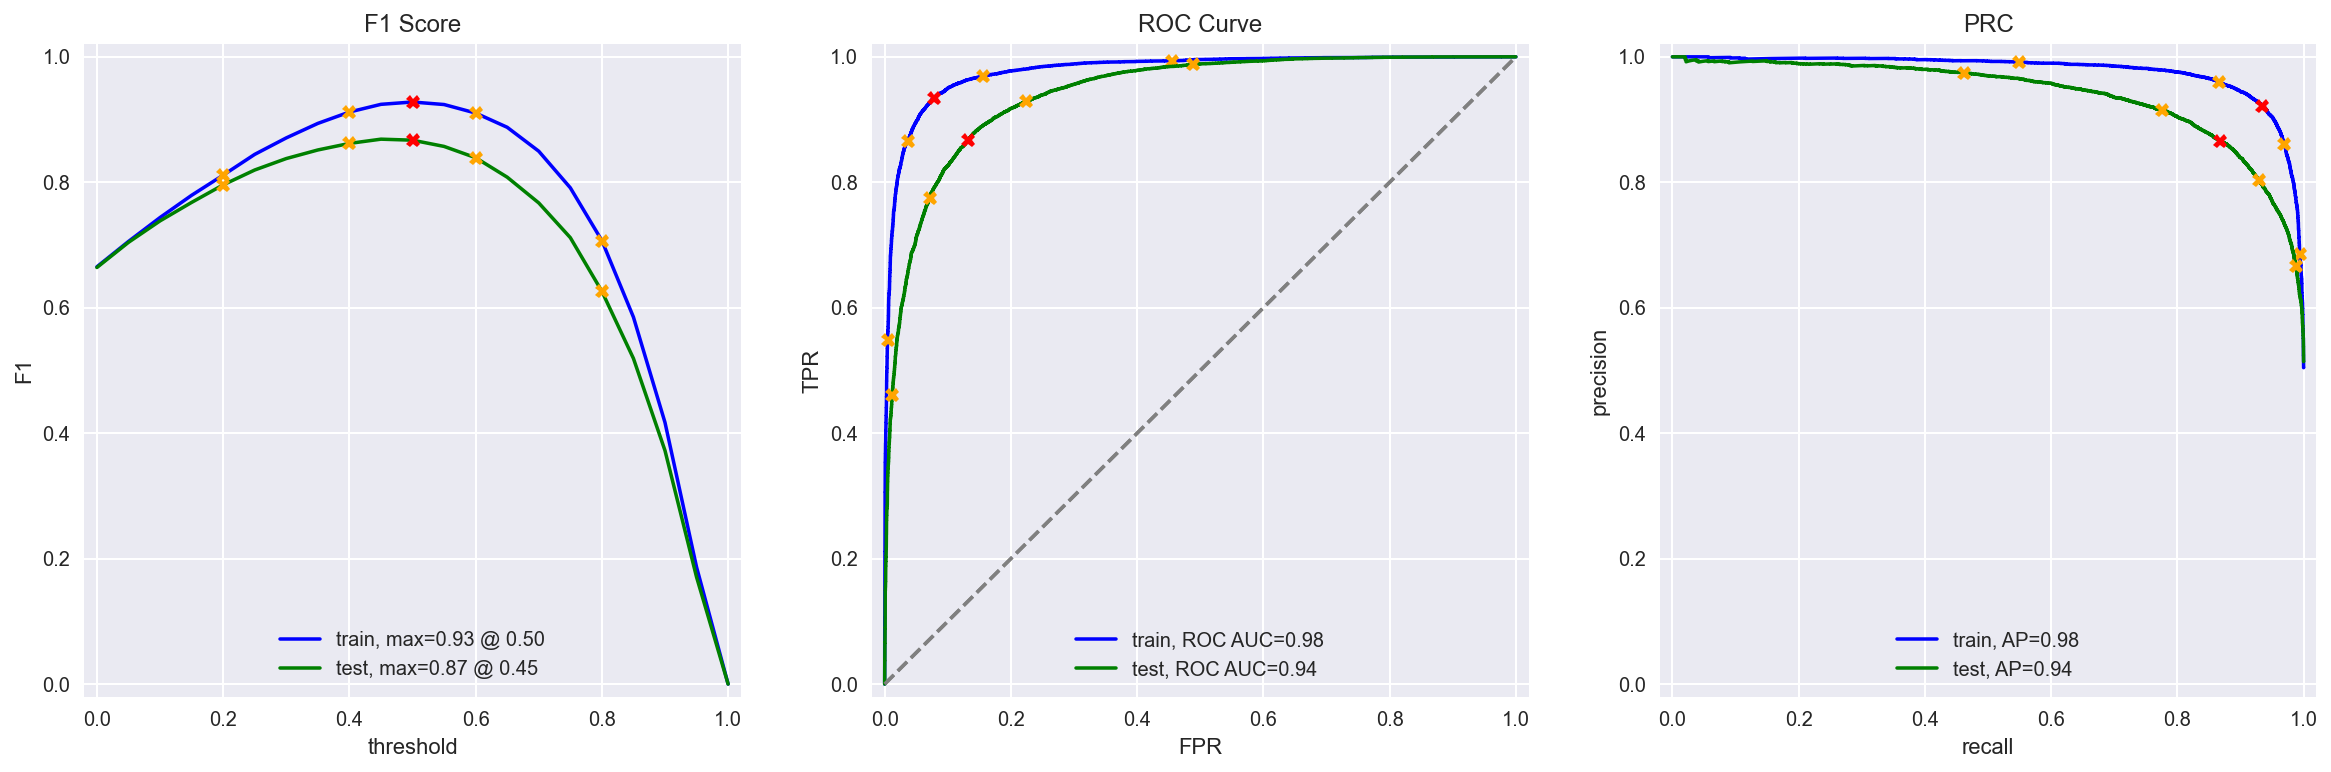

In [87]:
# train and evaluate the model
lr_model_cut = LogisticRegression(random_state=12345, solver='liblinear') 
scores = cross_val_score(lr_model_cut, tf_idf_X1, y_train_cut, cv=5, scoring='f1')
lr_model_cut.fit(tf_idf_X1, y_train_cut) 

# check the prediction performance
evaluate_model(lr_model_cut, tf_idf_X1, y_train_cut, tf_idf_X2, y_test_cut) 

| 		| 	Training	 | 		 | 		 | 		 | 	Test	 | 		 | 		 | 		 | 
|---		| 		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 		| 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 | 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 | 
|---		| 		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 	Dataset D	| 	0.93	 | 	0.93	 | 	0.98	 | 	0.98	 | 	0.87	 | 	0.87	 | 	0.94	 | 	0.94	 | 
| 	Dataset E	| 	0.92	 | 	0.92	 | 	0.98	 | 	0.98	 |	0.85	 |	0.85	 |	0.93	 |	0.93	 |
| 	Dataset F	| 	0.72	 | 	0.62	 | 	0.8	 | 	0.84	 |	0.69	 |	0.59	 |	0.78	 |	0.8	 |


The model performed on dataset D (last-176-token-extract of 'review') almost as well as on dastaset A (full length 'review'). This implies that:

* The logistic regression model eats up even the longest review comprising of 2495 tokens before breakfast!
* The most important information tends to be found towards the end of 'review'. So if a corpus comes with extremely long texts, we do have an option of truncating them to a certain fixed length (e.g. down to the median number of tokens). 

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Yeah, well, the length of the review doesn't really make a difference if we're using TF-IDF vectorization: the number of features is the same regardless
	  
</div>

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [88]:
import lightgbm as lgb

In [98]:
# without biggrams
tfidf_vectorizer_4 = TfidfVectorizer(stop_words=stop_words)

# with bigrams
#tfidf_vectorizer_4 = TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2))

In [99]:
# dataset (A-spaCy)
tfidf_vectorizer_4.fit(X_train_min_spacy['review_spacy']) 

# dataset (B-spaCy)
#ctfidf_vectorizer_4.fit(X_train_add1_spacy['review_spacy']) 

# dataset (C-spaCy)
#ct_4 = ColumnTransformer([(x, TfidfVectorizer(stop_words=stop_words), x) for x in ['review_spacy', 'genres_spacy']]) # without bigrams
#ct_4 = ColumnTransformer([(x, TfidfVectorizer(stop_words=stop_words, ngram_range=(2,2)), x) for x in ['review_spacy', 'genres_spacy']]) # with bigrams
#ct_4.fit(X_train_add2_spacy)

TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [100]:
# dataset (A-spaCy): (23516, 58763) without bigrams; (23516, 1470291) with bigrams
tf_idf_train_spacy = tfidf_vectorizer_4.transform(X_train_min_spacy['review_spacy']) 

# dataset (B-spaCy): (23516, 58763) without bigrams; (23516, 1470291) with bigrams
#tf_idf_train_spacy = tfidf_vectorizer_4.transform(X_train_add1_spacy['review_spacy']) 

# dataset (C-spaCy): (23516, 58795) without bigrams; (23516, 1470490) with bigrams
#tf_idf_train_spacy = ct_4.transform(X_train_add2_spacy) 

tf_idf_train_spacy.shape

(23516, 58763)

In [101]:
# dataset (A-spaC-spaCy: (23242, 58763) without bigrams; (23242, 1470291) with bigrams
tf_idf_test_spacy = tfidf_vectorizer_4.transform(X_test_min_spacy['review_spacy']) 

# dataset (B-spaCy): (23242, 58763) without bigrams; (23242, 1470291) with bigrams 
#tf_idf_test_spacy = tfidf_vectorizer_4.transform(X_test_add1_spacy['review_spacy']) 

# dataset (C-spaCy): (23242, 58795) without bigrams; (23242, 1470490) with bigrams
#tf_idf_test_spacy = ct_4.transform(X_test_add2_spacy) 

tf_idf_test_spacy.shape

(23242, 58763)

In [103]:
# an initial run with dataset (A)
start = time.time()
print("Starting the training at", start)

model_4 = lgb.LGBMClassifier()
model_4.fit(tf_idf_train_spacy, train_target, eval_set=(tf_idf_test_spacy, test_target), feature_name='auto')

end = time.time()
print("Ending the training at", end)
print(end - start, 's')

Starting the training at 1637091452.3312411
[1]	valid_0's binary_logloss: 0.663077
[2]	valid_0's binary_logloss: 0.638718
[3]	valid_0's binary_logloss: 0.618025
[4]	valid_0's binary_logloss: 0.600719
[5]	valid_0's binary_logloss: 0.584873
[6]	valid_0's binary_logloss: 0.572165
[7]	valid_0's binary_logloss: 0.560119
[8]	valid_0's binary_logloss: 0.549515
[9]	valid_0's binary_logloss: 0.539082
[10]	valid_0's binary_logloss: 0.530118
[11]	valid_0's binary_logloss: 0.522545
[12]	valid_0's binary_logloss: 0.51555
[13]	valid_0's binary_logloss: 0.50813
[14]	valid_0's binary_logloss: 0.502361
[15]	valid_0's binary_logloss: 0.496188
[16]	valid_0's binary_logloss: 0.490962
[17]	valid_0's binary_logloss: 0.485183
[18]	valid_0's binary_logloss: 0.479057
[19]	valid_0's binary_logloss: 0.475044
[20]	valid_0's binary_logloss: 0.470035
[21]	valid_0's binary_logloss: 0.465072
[22]	valid_0's binary_logloss: 0.460921
[23]	valid_0's binary_logloss: 0.457049
[24]	valid_0's binary_logloss: 0.452583
[25]	va

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


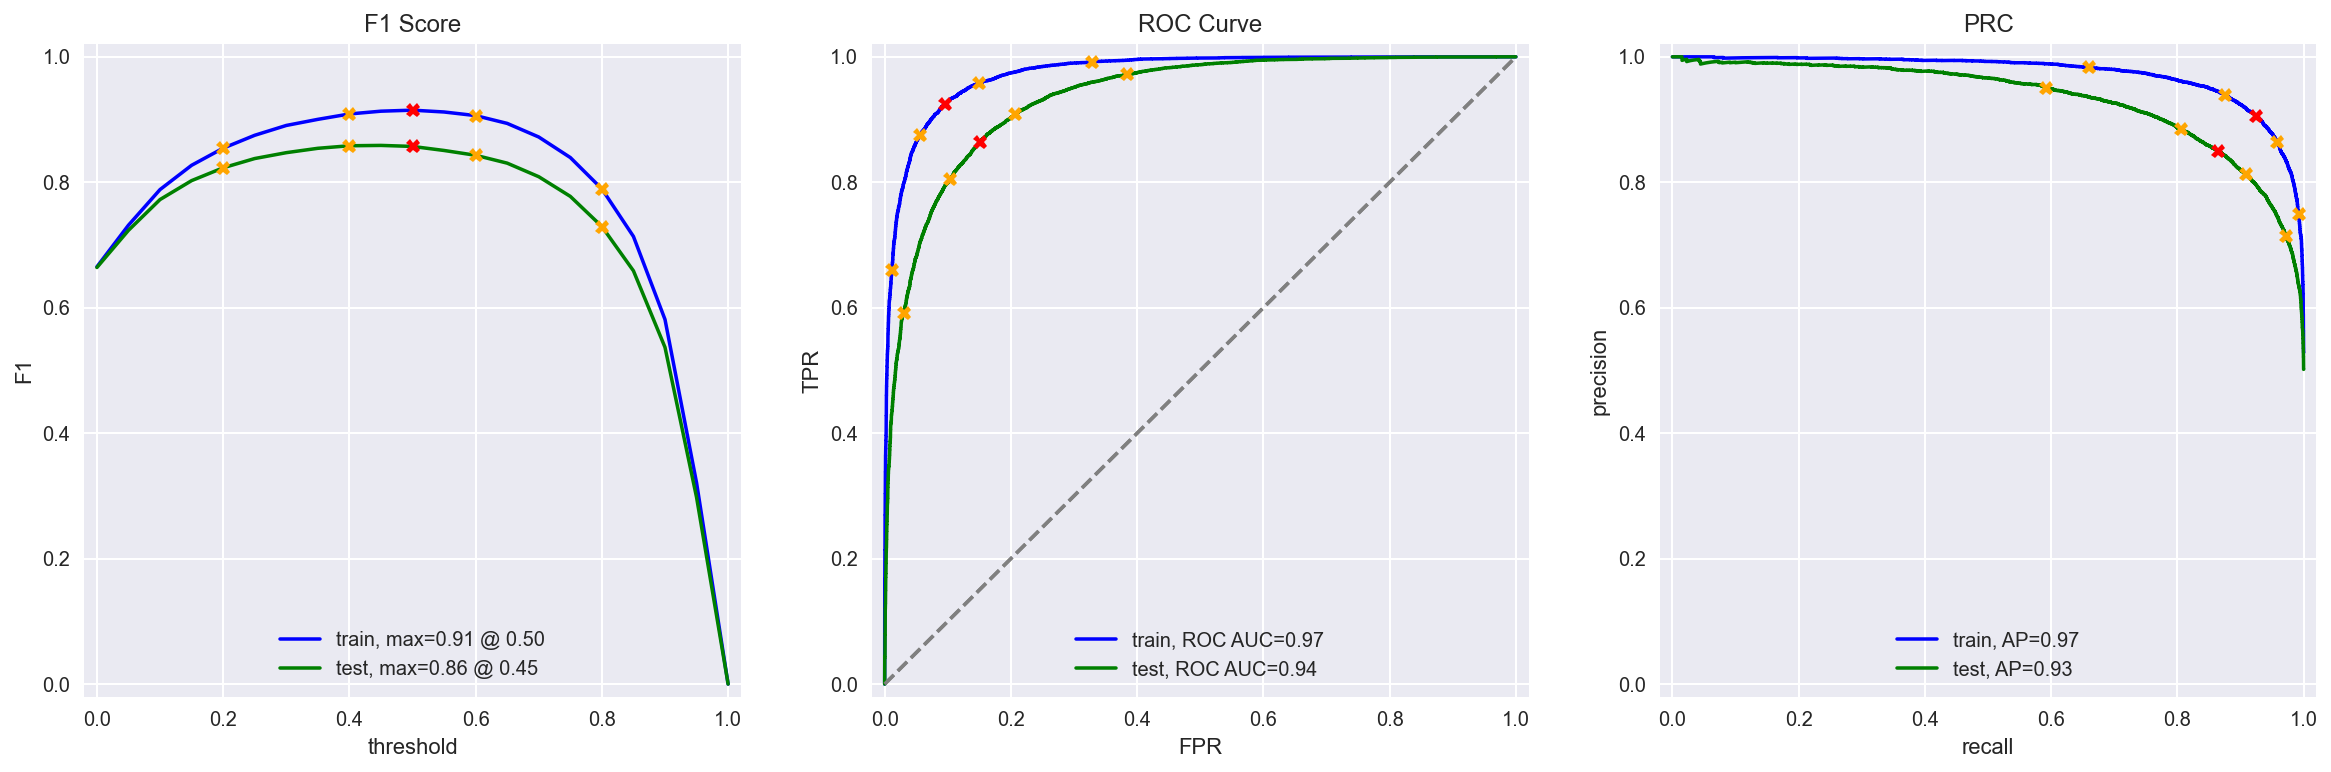

In [104]:
evaluate_model(model_4, tf_idf_train_spacy, train_target, tf_idf_test_spacy, test_target) 

* Without bigrams

| 		| 	Training	 | 		 | 		 | 		 | 	Test	 | 		 | 		 | 		 | 
|---		| 		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 		| 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 | 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 | 
|---		| 		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 	Dataset A	| 	0.91	 | 	0.91	 | 	0.97	 | 	0.97	 | 	0.86	 | 	0.86	 | 	0.93	 | 	0.94	 | 
| 	Dataset B	| 	0.91	 | 	0.91	 | 	0.97	 | 	0.97	 |	0.86	 |	0.86	 |	0.93	 |	0.94	 |
| 	Dataset C	| 	0.92	 | 	0.92	 | 	0.97	 | 	0.97	 |	0.86	 |	0.86	 |	0.93	 |	0.94	 |


* With bigrams

| 		| 	Training	 | 		 | 		 | 		| 	Test	 | 		 | 		 | 		 |
|---		|---		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 		| 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	| 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 |
|---		|---		|----------		|----------		|----------		|---		|----------		|----------		|----------		 |
| 	Dataset A	| 	0.84	 | 	0.85	 | 	0.92	 | 	0.93	 |	0.78	 |	0.79	 |	0.86	 |	0.87	 |
| 	Dataset B	| 	0.84	 | 	0.85	 | 	0.92	 | 	0.93	 |	0.78	 |	0.79	 |	0.86	 |	0.87	 |
| 	Dataset C	| 	0.84	 | 	0.85	 | 	0.93	 | 	0.93	 |	0.78	 |	0.78	 |	0.86	 |	0.86	 |


Bigrams do not help improve the F1 score. Since the score is the same for dataset A and B and dataset A is simpler, we will use dataset A for hyperparameter tuning.



First find the best parameters using RandomizedSearchCV.

In [105]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

In [106]:
# specify your configurations as dictionaries
params = {'objective': ['binary'],
          'metric': ['auc'],
          'learning_rate': [0.05, 0.1, 0.3],
          'max_depth': [6, 8, 10],
          'num_leaves': [20, 200], # maximum limit to num_leaves should be 2^(max_depth)
          'n_estimators': [50, 250],
          'min_data_in_leaf': [100, 200]
        }

start = time.time()
print("Starting the training at", start)

model_4 = lgb.LGBMClassifier()
search_grid = RandomizedSearchCV(model_4, param_distributions=params, verbose=50, cv=5, random_state=12345)
search_grid.fit(tf_idf_train_spacy, train_target)

end = time.time()
print("Ending the training at", end)
print(end - start, 's')

Starting the training at 1637091568.298579
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START learning_rate=0.05, max_depth=6, metric=auc, min_data_in_leaf=200, n_estimators=50, num_leaves=20, objective=binary
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[CV 1/5; 1/10] END learning_rate=0.05, max_depth=6, metric=auc, min_data_in_leaf=200, n_estimators=50, num_leaves=20, objective=binary;, score=0.774 total time=   3.2s
[CV 2/5; 1/10] START learning_rate=0.05, max_depth=6, metric=auc, min_data_in_leaf=200, n_estimators=50, num_leaves=20, objective=binary
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[CV 2/5; 1/10] END learning_rate=0.05, max_depth=6, metric=auc, min_data_in_leaf=200, n_estimators=50, num_leaves=20, objective=binary;, score=0.781 total time=   3.1s
[CV 3/5; 1/10] START learning_rate=0.0

In [107]:
print('Best params:', search_grid.best_params_)

Best params: {'objective': 'binary', 'num_leaves': 200, 'n_estimators': 250, 'min_data_in_leaf': 100, 'metric': 'auc', 'max_depth': 6, 'learning_rate': 0.3}


          train  test
Accuracy   0.96  0.86
F1         0.96  0.87
APS        0.99  0.94
ROC AUC    0.99  0.94


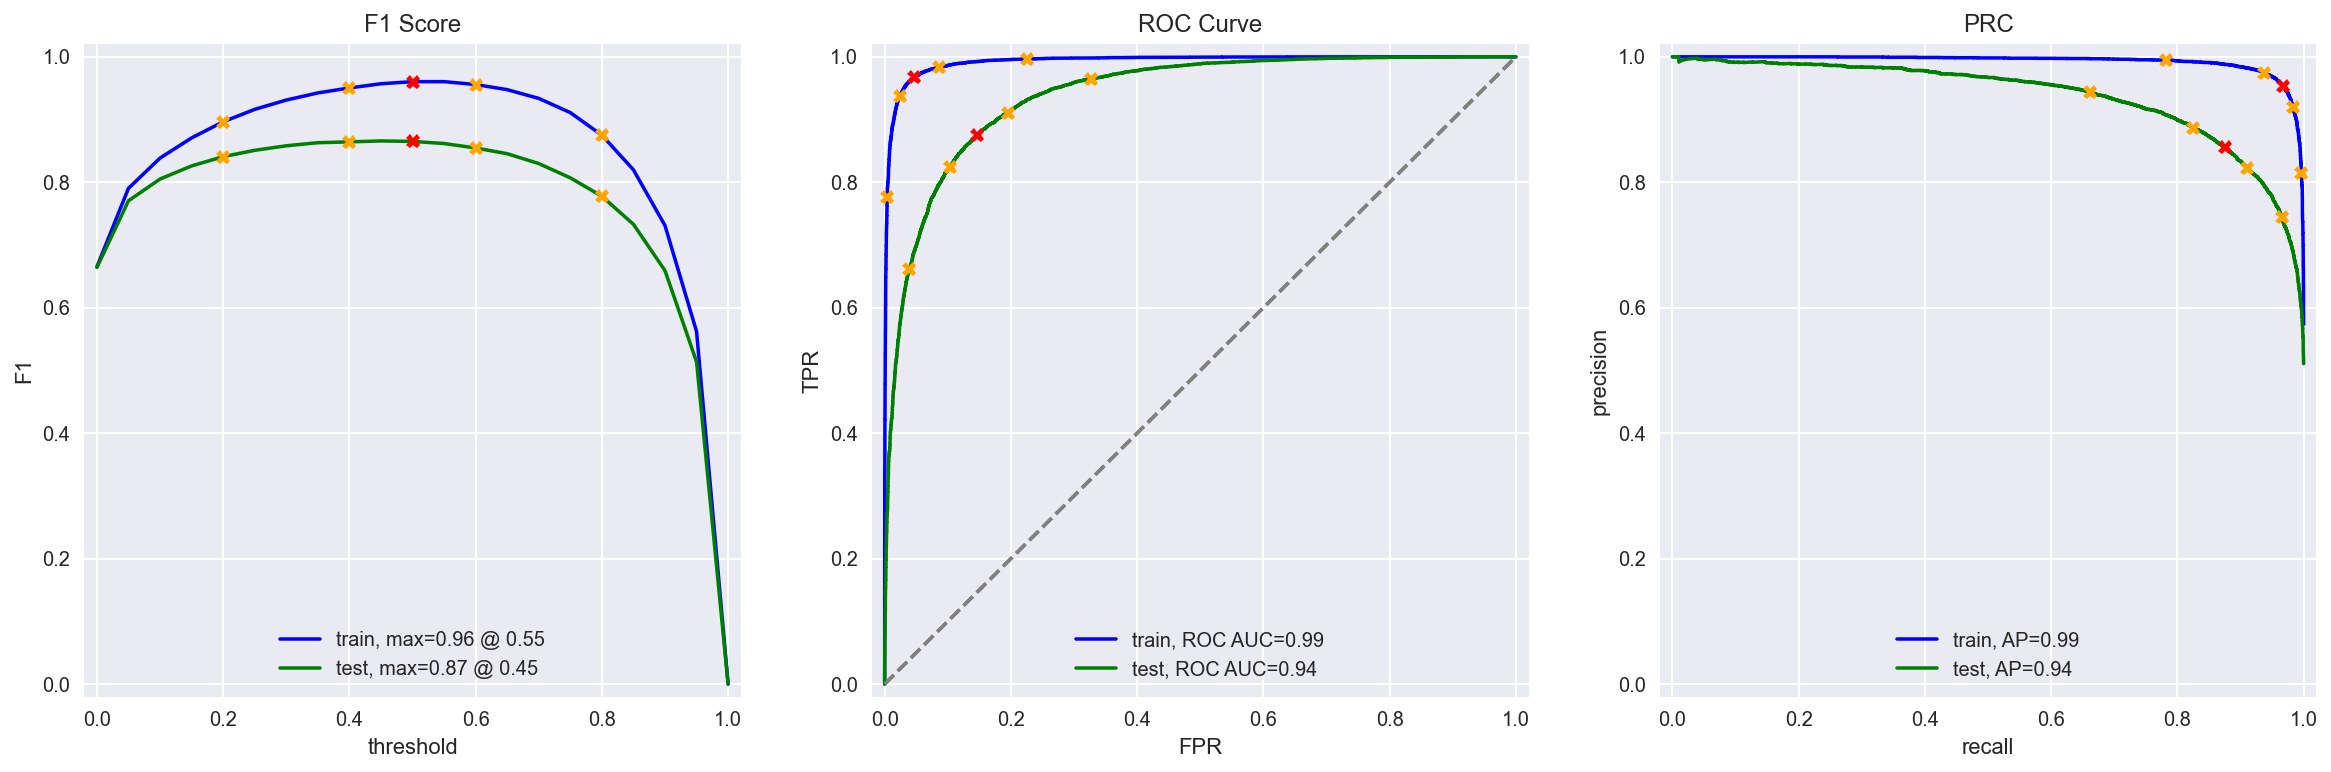

In [108]:
evaluate_model(search_grid, tf_idf_train_spacy, train_target, tf_idf_test_spacy, test_target) 

Find the best parameters with Optuna.

In [123]:
!pip install optuna
import optuna
from sklearn.pipeline import Pipeline
import pickle
from joblib import dump
from optuna.integration import LightGBMPruningCallback
from lightgbm import LGBMClassifier

In [124]:
model_5 = Pipeline([
    ('tfidf', ColumnTransformer([(x, TfidfVectorizer(stop_words=stop_words), x) for x in ['review_spacy']])),
    ('lgbc', LGBMClassifier(objective='binary'))])

In [129]:
#def objective(trial, X1, y1, X2, y2):
def objective(trial, X, y):
    
    dump(study, 'study.pkl')

    lgbc__num_leaves = trial.suggest_int('lgbc__num_leaves', 2, 150) 
    lgbc__max_depth = trial.suggest_int('lgbc__max_depth', 2, 100) 
    lgbc__n_estimators = trial.suggest_int('lgbc__n_estimators', 10, 200) 
    lgbc__learning_rate = trial.suggest_loguniform('lgbc__learning_rate', 0.05, 0.3)   

    params = {
        'lgbc__num_leaves': lgbc__num_leaves,
        'lgbc__max_depth': lgbc__max_depth,
        'lgbc__n_estimators': lgbc__n_estimators,      
        'lgbc__learning_rate': lgbc__learning_rate
    }
   
    #scores = cross_val_score(lgbc_model, X1, y1, cv=8, scoring='f1_weighted') # cv=repeated_split
    scores = cross_val_score(model_5, X, y, cv=8, scoring='f1_weighted') 
    #lgbc_model.fit(X1, y1)
    model_5.fit(X, y) # early_stopping_rounds=100, callbacks=[LightGBMPruningCallback(trial, "auc")] are not accepted

    return np.mean(scores)

In [130]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
#repeated_split = RepeatedKFold(n_splits=5, n_repeats=2, random_state=12345)
#func = lambda trial: objective(trial, X_train_min_spacy, train_target, X_test_min_spacy, test_target)
func = lambda trial: objective(trial, X_train_min_spacy, train_target)
study.optimize(func, n_trials=10)

[I 2021-11-16 22:29:00,653] A new study created in memory with name: LGBM Classifier
[I 2021-11-16 22:33:03,673] Trial 0 finished with value: 0.8528080344239796 and parameters: {'lgbc__num_leaves': 37, 'lgbc__max_depth': 82, 'lgbc__n_estimators': 93, 'lgbc__learning_rate': 0.11024754739308013}. Best is trial 0 with value: 0.8528080344239796.
[I 2021-11-16 22:37:07,264] Trial 1 finished with value: 0.8528080344239796 and parameters: {'lgbc__num_leaves': 142, 'lgbc__max_depth': 45, 'lgbc__n_estimators': 125, 'lgbc__learning_rate': 0.07139116070804703}. Best is trial 0 with value: 0.8528080344239796.
[I 2021-11-16 22:41:09,631] Trial 2 finished with value: 0.8528080344239796 and parameters: {'lgbc__num_leaves': 122, 'lgbc__max_depth': 100, 'lgbc__n_estimators': 47, 'lgbc__learning_rate': 0.2911418930231043}. Best is trial 0 with value: 0.8528080344239796.
[I 2021-11-16 22:45:12,132] Trial 3 finished with value: 0.8528080344239796 and parameters: {'lgbc__num_leaves': 19, 'lgbc__max_depth':

In [131]:
print(f"\tBest value (F1 score): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (F1 score): 0.85281
	Best params:
		lgbc__num_leaves: 37
		lgbc__max_depth: 82
		lgbc__n_estimators: 93
		lgbc__learning_rate: 0.11024754739308013


In [133]:
# train a new instance of the model with the suggested set of best hyperparameters
model_5 = lgb.LGBMClassifier(
    num_leaves=37, # 110
    max_depth=82, # 95
    n_estimatoers=93, #197
    learning_rate=0.11024754739308013 # 0.2543446480589004
)
model_5.fit(tf_idf_train_spacy, train_target, 
              eval_set=(tf_idf_test_spacy, test_target), 
              feature_name='auto'
)

[1]	valid_0's binary_logloss: 0.659571
[2]	valid_0's binary_logloss: 0.632774
[3]	valid_0's binary_logloss: 0.609903
[4]	valid_0's binary_logloss: 0.591345
[5]	valid_0's binary_logloss: 0.574632
[6]	valid_0's binary_logloss: 0.560791
[7]	valid_0's binary_logloss: 0.54821
[8]	valid_0's binary_logloss: 0.536233
[9]	valid_0's binary_logloss: 0.526931
[10]	valid_0's binary_logloss: 0.517729
[11]	valid_0's binary_logloss: 0.509878
[12]	valid_0's binary_logloss: 0.501962
[13]	valid_0's binary_logloss: 0.495023
[14]	valid_0's binary_logloss: 0.488607
[15]	valid_0's binary_logloss: 0.483138
[16]	valid_0's binary_logloss: 0.477306
[17]	valid_0's binary_logloss: 0.470702
[18]	valid_0's binary_logloss: 0.465225
[19]	valid_0's binary_logloss: 0.460326
[20]	valid_0's binary_logloss: 0.455473
[21]	valid_0's binary_logloss: 0.451288
[22]	valid_0's binary_logloss: 0.446564
[23]	valid_0's binary_logloss: 0.442164
[24]	valid_0's binary_logloss: 0.438376
[25]	valid_0's binary_logloss: 0.434584
[26]	valid

LGBMClassifier(learning_rate=0.11024754739308013, max_depth=82,
               n_estimatoers=93, num_leaves=37)

          train  test
Accuracy   0.93  0.86
F1         0.93  0.86
APS        0.98  0.94
ROC AUC    0.98  0.94


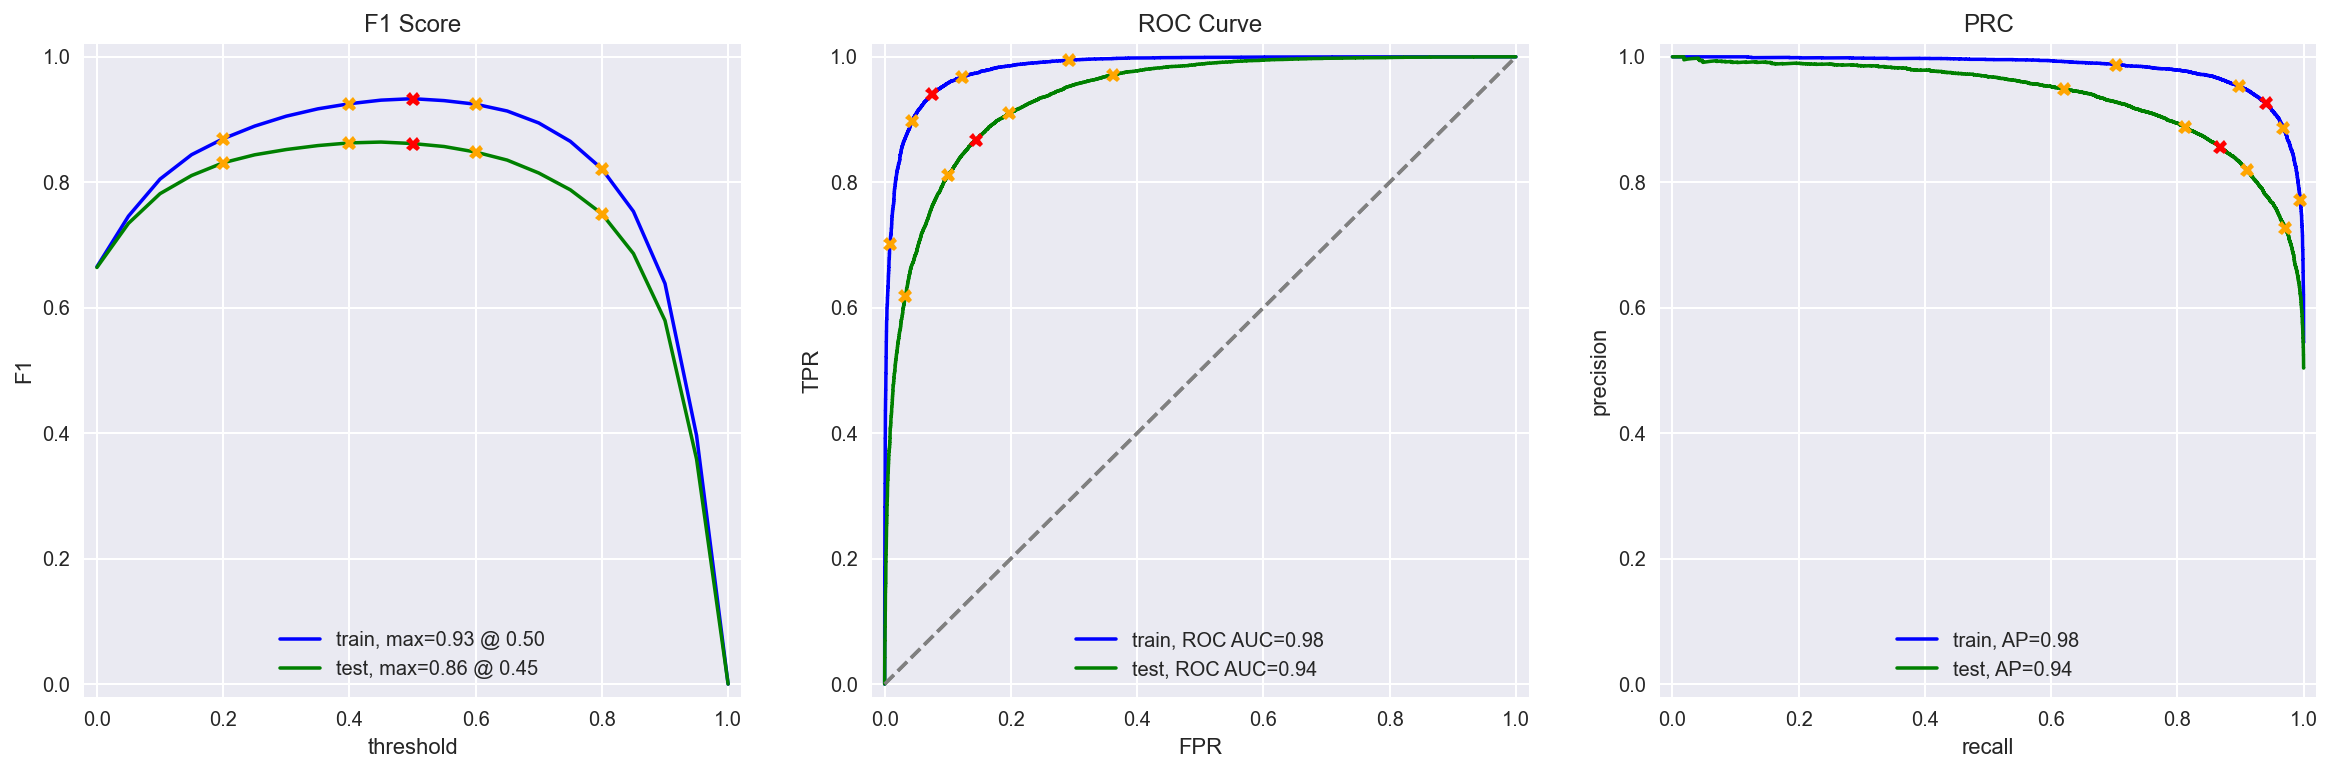

In [134]:
evaluate_model(model_5, tf_idf_train_spacy, train_target, tf_idf_test_spacy, test_target) 

| 		| 	Training	 | 		 | 		 | 		 | 	Test	 | 		 | 		 | 		 | 		 | 		 | 		 | 		 | 		 | 
|---		| 		|----------		|----------		|----------		|---		|----------		|----------		|----------		|----------		|----------		|----------		|----------		|----------		 |
| 		| 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 | 	Accuracy	 | 	F1	 | 	APS	 | 	ROC-AUC	 | 	learning_rate	 | 	max_depth	 | 	n_estimatoers	 | 	num_leaves	 | 	min_data_in_leaf	 | 
|---		| 		|----------		|----------		|----------		|---		|----------		|----------		|----------		|----------		|----------		|----------		|----------		|----------		 |
| 	RandomizedSearchCV	| 	0.96	 | 	0.96	 | 	0.99	 | 	0.99	 | 	0.86	 | 	0.87	 | 	0.94	 | 	0.94	 | 	0.3	 | 	6	 | 	250	 | 	200	 | 	100	 | 
| 	Optuna	| 	0.93	 | 	0.93	 | 	0.98	 | 	0.98	 |	0.86	 |	0.86	 |	0.94	 |	0.94	 |	0.110247547	 |	82	 |	93	 |	37	 |	-	 |


The hyperparameters chosen by RandomizedSearchCV scored higher in F1 than those suggested by Optuna. But the set chosen by Optuna makes the model more simple.  


Optuna allows for a finer-tuning since the practioner can specify a range than having to second-guess possible values, only out of which RandomizedSearchCV will choose. 

study.pkl file was created in the local folder. 

<div class="alert alert-info" role="alert"> 
<b>Comment</b> 

<br>early_stopping_rounds=100 and callbacks=[LightGBMPruningCallback(trial, "auc")] were not accepted in the code, despite following an example I found, so could not be implemented. 
</div>

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Very nice, you also tried lightgbm and tuned its hyperparameters!
	  
</div>

###  Model 9 - BERT

Prepare a smaller dataset out of the original. Taking a couple hundred of objects per each part of the (train/test) dataset to avoid waiting too long.

In [109]:
# making sure an absolute class balance in the training and test datasets
df_reviews_train_bert1 = df_reviews.query('ds_part == "train" & pos == 1')[['review', 'pos']].sample(200) # the score worsened with 250
df_reviews_train_bert0 = df_reviews.query('ds_part == "train" & pos == 0')[['review', 'pos']].sample(200)
df_reviews_train_bert = pd.concat([df_reviews_train_bert1, df_reviews_train_bert0])

df_reviews_test_bert1 = df_reviews.query('ds_part == "test" & pos == 1')[['review', 'pos']].sample(200)
df_reviews_test_bert0 = df_reviews.query('ds_part == "test" & pos == 0')[['review', 'pos']].sample(200)
df_reviews_test_bert = pd.concat([df_reviews_test_bert1, df_reviews_test_bert0])

In [111]:
import torch
import transformers

In [112]:
# initialize the tokenizer as an instance of BertTokenizer() with the name of the pre-trained model
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased') # changed from 'bert-base-uncased'

# getting embeddings
config = transformers.BertConfig.from_pretrained('bert-base-uncased') # changed from 'bert-base-uncased'
model = transformers.BertModel.from_pretrained('bert-base-uncased') # changed from 'bert-base-uncased'

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<div class="alert alert-info" role="alert"> 
<b>Comment</b> 

<br>I think 'cased' will work better at sentiment analysis since "BAD" conveys negativity a lot more strongly than "bad". But I am using 'uncased' since up until now, I converted 'review' to lowercase for all the models. 
</div>

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Maybe! I'm not sure it wouldn't make that much of a difference though; you'd have to try it out to find out anyway :)
	  
</div>

In [113]:
# the BERT model creates embeddings in batches. Make the batch size small so that the RAM won't be overwhelmed:
# changed from batch_size=100 to batch_size=25
def BERT_text_to_embeddings(texts, max_length=512, batch_size=25, force_device=None, disable_progress_bar=False): 
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
        
    # <put your code here to create ids_list and attention_mask_list>
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    
    #if force_device is not None:
    #    device = torch.device(force_device)
    #else:
    #    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    device = torch.device(force_device if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using the {device} device.')
    model.to(device)
    
    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The function for generating embeddings using BERT is correct
	  
</div>

In [114]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours

# the original code - why use 'review_norm'? BERT does not require lemmatization anyway
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda') 

train_features_9 = BERT_text_to_embeddings(df_reviews_train_bert['review'], force_device='cuda')
test_features_9 = BERT_text_to_embeddings(df_reviews_test_bert['review'], force_device='cuda')

Using the cpu device.
Using the cpu device.


<ipython-input-113-8de6c5201c23>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)



Using the cpu device.
Using the cpu device.


In [117]:
train_target_bert = df_reviews_train_bert['pos']
test_target_bert = df_reviews_test_bert['pos']

In [118]:
# the original code - why use 'review_norm'? BERT does not require lemmatization anyway 
#print(df_reviews_train['review_norm'].shape)

print(df_reviews_train['review'].shape)
print(train_features_9.shape)
print(train_target_bert.shape)
print(test_features_9.shape)
print(test_target_bert.shape)

(23516,)
(400, 768)
(400,)
(400, 768)
(400,)


In [119]:
# create a logistic regression model
model_9 = LogisticRegression(random_state=12345, solver='liblinear') 
scores = cross_val_score(model_9, train_features_9, train_target_bert, cv=10, scoring='f1')
print('mean F1 score:', np.mean(scores))

mean F1 score: 0.7901449362387215


          train  test
Accuracy    1.0  0.82
F1          1.0  0.82
APS         1.0  0.87
ROC AUC     1.0  0.89


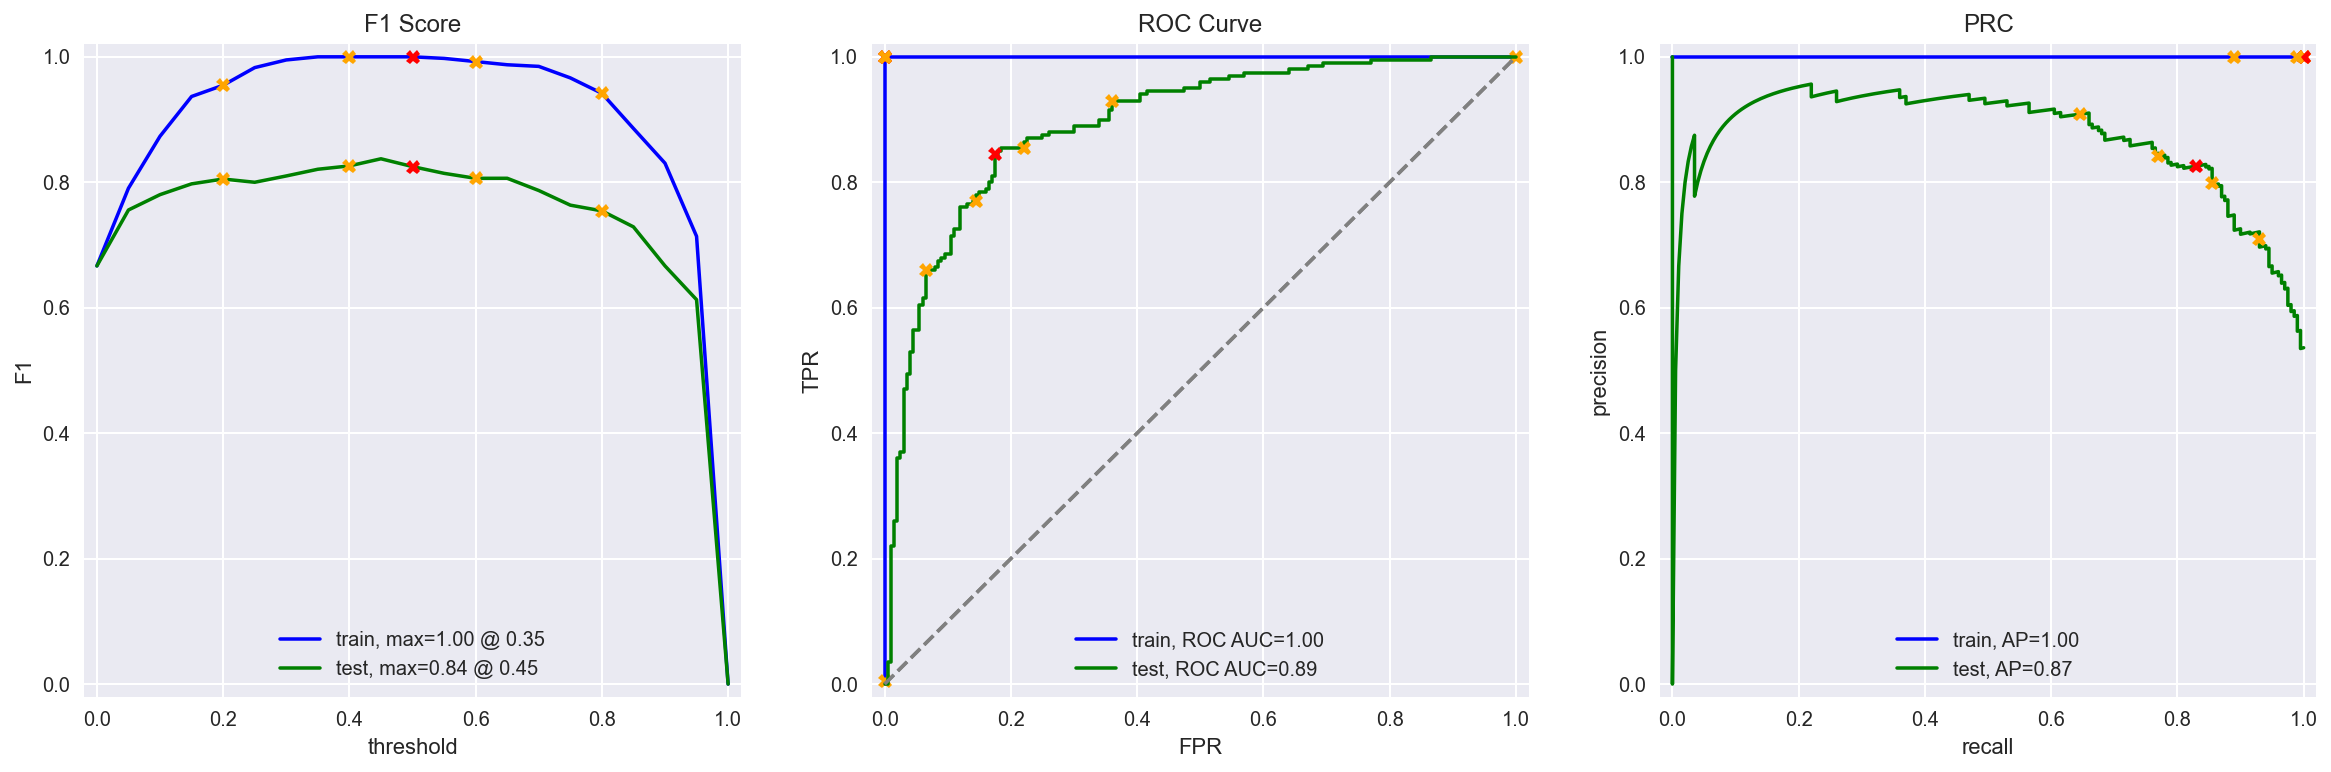

In [120]:
# train the model 
model_9.fit(train_features_9, train_target_bert)
evaluate_model(model_9, train_features_9, train_target_bert, test_features_9, test_target_bert)

The model did not manage to reach the project's threhold of 0.85. 

The model performed worse on a training dataset containing 250 observations than on a 200 observations. It is possible that the model may have picked itself up after the dip, had we tried 300 observations. 

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Still, a respectable performance considering you trained it on such a small dataset! 
	  
</div>

In [145]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

features_9.npz has been created in the local folder. 

## My Reviews

In [152]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.',
    'I have decided not to give this one a rating at all because I have no strong feelings one way or the other.',
    'It was one of the saddest movies I have ever watched, and I loved it.',
    'When the murderer finally died, I had tears in my eyes.'
], columns=['review'])

# <put here the same normalization logic as for the main dataset>
my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: clear_text(x))
my_reviews['review_norm'] = my_reviews['review_norm'].apply(lambda x: lemmatize_nlp(x))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i wa bored and felt asleep in the middle ...
2,I was really fascinated with the movie,i wa really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actor looked really old and disintere...
4,I didn't expect the reboot to be so good! Writ...,i did n't expect the reboot to be so good writ...
5,"The movie had its upsides and downsides, but I...",the movie had it upside and downside but i fee...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix wa a brave move i really ...
8,I have decided not to give this one a rating a...,i have decided not to give this one a rating a...
9,It was one of the saddest movies I have ever w...,it wa one of the saddest movie i have ever wat...


### Model 1

(Originally, the precode marked this as "Model 2". There is no Model 2 above.)

In [153]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.16:  i did not simply like it not my kind of movie
0.14:  well i wa bored and felt asleep in the middle of the movie
0.46:  i wa really fascinated with the movie
0.12:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.30:  i did n't expect the reboot to be so good writer really cared about the source material
0.53:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.04:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.88:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod
0.81:  i have decided not to give this one a rating at all because i have no strong feeling one way or the 
0.78:  it wa one of the saddest movie i have ever watched and i loved it
0.76:  when the murderer finally died i had tear in my eye


### Model 3

In [154]:
texts = my_reviews['review_norm']

#my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it not my kind of movie
0.20:  well i wa bored and felt asleep in the middle of the movie
0.49:  i wa really fascinated with the movie
0.26:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.35:  i did n't expect the reboot to be so good writer really cared about the source material
0.52:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.92:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod
0.83:  i have decided not to give this one a rating at all because i have no strong feeling one way or the 
0.47:  it wa one of the saddest movie i have ever watched and i loved it
0.77:  when the murderer finally died i had tear in my eye


### Model 4

In [155]:
texts = my_reviews['review_norm']

#tfidf_vectorizer_4 = tfidf_vectorizer_3
#my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
my_reviews_pred_prob = search_grid.predict_proba(tfidf_vectorizer_4.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.48:  i did not simply like it not my kind of movie
0.27:  well i wa bored and felt asleep in the middle of the movie
0.61:  i wa really fascinated with the movie
0.55:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.50:  i did n't expect the reboot to be so good writer really cared about the source material
0.55:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.31:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.83:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod
0.72:  i have decided not to give this one a rating at all because i have no strong feeling one way or the 
0.59:  it wa one of the saddest movie i have ever watched and i loved it
0.68:  when the murderer finally died i had tear in my eye


### Model 5

In [156]:
texts = my_reviews['review_norm']

#tfidf_vectorizer_5 = tfidf_vectorizer_3
#my_reviews_pred_prob = model_5.predict_proba(tfidf_vectorizer_5.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]
my_reviews_pred_prob = model_5.predict_proba(tfidf_vectorizer_4.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  i did not simply like it not my kind of movie
0.36:  well i wa bored and felt asleep in the middle of the movie
0.57:  i wa really fascinated with the movie
0.41:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.66:  i did n't expect the reboot to be so good writer really cared about the source material
0.69:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.21:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.81:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod
0.64:  i have decided not to give this one a rating at all because i have no strong feeling one way or the 
0.57:  it wa one of the saddest movie i have ever watched and i loved it
0.70:  when the murderer finally died i had tear in my eye


### Model 9

In [157]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Using the cpu device.
0.58:  i did not simply like it not my kind of movie
0.47:  well i wa bored and felt asleep in the middle of the movie
0.81:  i wa really fascinated with the movie
0.39:  even the actor looked really old and disinterested and they got paid to be in the movie what a soull
0.47:  i did n't expect the reboot to be so good writer really cared about the source material
0.66:  the movie had it upside and downside but i feel like overall it 's a decent flick i could see myself
0.56:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wo 
0.87:  launching on netflix wa a brave move i really appreciate being able to binge on episode after episod
0.44:  i have decided not to give this one a rating at all because i have no strong feeling one way or the 
1.00:  it wa one of the saddest movie i have ever watched and i loved it
0.92:  when the murderer finally died i had tear in my eye


<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Models were applied to custom reviews successfully
	  
</div>

# Conclusions

| 		| 	review	 | 	pos	 | 	model1	 | 	model3	 |	model4	 |	model5	 |	model9	 |
|---		|---		|----------		 | 		|----------		|----------		|----------		|----------		 |
| 	0	| 	I did not simply like it, not my kind of movie.	 | 	0	 | 	0	 | 	0	 |	0	 |	1	 |	1	 |
| 	1	| 	Well, I was bored and felt asleep in the middl...	 | 	0	 | 	0	 | 	0	 |	0	 |	0	 |	0	 |
| 	2	| 	I was really fascinated with the movie	 | 	1	 | 	1	 | 	0	 |	1	 |	1	 |	1	 |
| 	3	| 	Even the actors looked really old and disinter...	 | 	0	 | 	0	 | 	0	 |	1	 |	0	 |	0	 |
| 	4	| 	I didn't expect the reboot to be so good! Writ...	 | 	1	 | 	0	 | 	0	 |	1	 |	1	 |	0	 |
| 	5	| 	The movie had its upsides and downsides, but I...	 | 	1	 | 	1	 | 	1	 |	1	 |	1	 |	1	 |
| 	6	| 	What a rotten attempt at a comedy. Not a singl...	 | 	0	 | 	0	 | 	0	 |	0	 |	0	 |	1	 |
| 	7	| 	Launching on Netflix was a brave move & I real...	| 	1	 | 	1	 | 	1	 |	1	 |	1	 |	1	 |
| 	8	| 	I have decided not to give this one a rating a...	| 	neutral	 | 	1	 | 	1	 |	1	 |	1	 |	0	 |
| 	9	| 	It was one of the saddest movies I have ever w...	| 	1	 | 	1	 | 	0	 |	1	 |	1	 |	1	 |
| 	10	| 	When the murderer finally died, I had tears in...	| 	1	 | 	1	 | 	1	 |	1	 |	1	 |	1	 |
| 	0	| 		| 	0	 | 	0.909090909	 | 	0.818181818	 |	0.909090909	 |	0.909090909	 |	0.636363636	 |


* The logistic regression model trained on the data lemmatised by spaCy and BERT performed less well than the others. The other models scored very high. 
* NLTK lemmatization produced better result than spaCy. 
* Probably all the models can be improved more through hyperparameter tuning. 

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Conclusions look good!
	  
</div>

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions